_Note: les outputs de certaines cellules ont été supprimées pour alléger le notebook_

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

# 1. Chargement et prise en main des données disponibles

## 1.1. Chargement

In [5]:
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_items = pd.read_csv('olist_order_items_dataset.csv',
                       parse_dates=['shipping_limit_date'])
df_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv',
                         parse_dates=['review_creation_date',
                                      'review_answer_timestamp'])
df_orders = pd.read_csv('olist_orders_dataset.csv',
                        parse_dates=['order_purchase_timestamp',
                                     'order_approved_at',
                                     'order_delivered_carrier_date',
                                     'order_delivered_customer_date',
                                     'order_estimated_delivery_date'])
df_products = pd.read_csv('olist_products_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_prod_cat_translation = pd.read_csv('product_category_name_translation.csv')


# Remarque: le dataset geolocalisation n'est pas chargé ici
# car il n'apporte que des infos supplémentaires de latitude et longitude

## 1.2. Aperçu des datasets

In [6]:
dfs = [df_customers,
       df_items,
       df_orders,
       df_payments,
       df_products,
       df_prod_cat_translation,
       df_reviews,
       df_sellers]

df_customers.name = 'df_customers'
df_items.name = 'df_items'
df_orders.name = 'df_orders'
df_payments.name = 'df_payments'
df_products.name = 'df_products'
df_prod_cat_translation.name = 'df_prod_cat_translation'
df_reviews.name = 'df_reviews'
df_sellers.name = 'df_sellers'

for df in dfs:
    print('-'*100)
    print('-'*100)
    print(df.name)
    print('-'*100)
    print(df.info(null_counts=True, max_cols=len(df.columns)))

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_customers
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
----------------------------------------------------------------------------------------------------
------------------------------------------

In [7]:
for df in dfs:
    print(df.name)
    display(HTML(df.head(2).to_html()))
    print('-'*100)
    print('-'*100)

df_customers


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_items


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_orders


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_payments


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_products


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_prod_cat_translation


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_reviews


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_sellers


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


## 1.3. description et utilisation potentielle des variables en vue de la segmentation

#### df_customers
- 'customer_id' --> key to the orders dataset. Each order has a unique customer_id.
- 'customer_unique_id' --> unique identifier of a customer. == individus pour clustering in fine
- 'customer_zip_code_prefix'
- 'customer_city'
- 'customer_state'
> regarder distribution de zip code, city et state (de customers et sellers aussi??) pour n'en conserver qu'un


#### df_items
- 'order_id'
- 'order_item_id' --> article numéro XX de la commande  
> max de 'order_item_id' par order_id = nb d'articles par commande = volume d'achat
- 'product_id'
- 'seller_id'
- 'shipping_limit_date' --> seller shipping limit date for handling the order over to the logistic partner.
- 'price' --> prix unitaire de chaque produit vendu (et non pas prix de l'ensemble de la commande)
- 'freight_value'--> frais de port par produit (et non pas de l'ensemble de la commande)

#### df_orders
- 'order_id'
- 'customer_id'
- 'order_status' --> pour tous ceux qui ne sont pas 'delivered', impossible d'évaluer le temps de livraison réel (si toutefois c'était utile d'évaluer ce temps)
- 'order_purchase_timestamp' --> purchase timestamp == timestamp de mise dans le panier????
- 'order_approved_at' --> payment approval timestamp == timestamp de passage effectif de la commande??? **NaN** pour commandes non finalisées A UTILISER POUR CLIENTS POTENTIELS (i.e. sont venus sur le site, étaient intéressés par des produits mais n'ont finalement pas acheté)
> différence entre 'order_purchase_timestamp' & 'order_approved_at' == temps entre création panier et transaction == pour discriminer acheteurs compulsifs ou qui savaient ce qu'ils voulaient acheter
> 'order_approved_at' à utiliser pour calculer la Récence et la Fréquence
- 'order_delivered_carrier_date' -->  order posting timestamp. When it was handled to the logistic partner. **NaN** pour commandes en cours, i.e. 'order_status' != 'delivered'
- 'order_delivered_customer_date' --> actual order delivery date to the customer. **NaN** pour commandes en cours, , i.e. 'order_status' != 'delivered'
- 'order_estimated_delivery_date' --> estimated delivery date that was informed to customer at the purchase moment.
> délai de livraison estimé = clients pressés (rejoignent les acheteurs compulsifs??)

#### df_payments
- 'order_id'
- 'payment_sequential' --> a customer may pay an order with more than one payment method. If he does so, a sequence will be created to
- 'payment_type'
- 'payment_installments' --> nb d'échelonnement du paiement --> reflète le revenu/niveau de vie du consommateur???
> lien avec prix panier moyen // reflet "niveau de vie" (dépensier ou pas) des clients??
- 'payment_value' --> montant total (i.e. de tous les articles) de la commande **ou payé à chaque 'payment_sequential'** (mais pas à chaque 'payment_installments')
> 'payment_value' à utiliser pour calculer le Montant (de la dernière commande ou sur période donnée) + pour calculer le panier Moyen

#### df_products
- 'product_id'
- 'product_category_name' --> root category of product, *in Portuguese*. **NaN** à supprimer si clustering inclut l'intérêt des consommateurs
- 'product_name_lenght' --> **TO DROP** - **NaN**
- 'product_description_lenght' --> **TO DROP** - **NaN**
- 'product_photos_qty' --> **TO DROP** - **NaN**
- 'product_weight_g' --> **TO DROP** - **NaN**
- 'product_length_cm' --> **TO DROP** - **NaN**
- 'product_height_cm' --> **TO DROP** - **NaN**
- 'product_width_cm' --> **TO DROP** - **NaN**

#### df_prod_cat_translation
- 'product_category_name' --> **TO DROP AFTER MERGE** (df_products, df_prod_cat_translation)
- 'product_category_name_english'


#### df_reviews
--> seulement 3886 commandes sans avis???
- 'review_id'
- 'order_id'
- 'review_score' --> Note ranging from 1 to 5 given by the customer on a satisfaction survey. == pour discriminer clients satisfaits vs insatisfaits??
- 'review_comment_title'  --> **TO DROP** - **NaN**
- 'review_comment_message' --> **TO DROP** - **NaN**
- 'review_creation_date' -->
- 'review_answer_timestamp' --> **TO DROP**

#### df_sellers
--> pour distinguer consommateurs favorisant le local vs autres?? si oui, conserver même variable que pour customers
- 'seller_id'
- 'seller_zip_code_prefix'
- 'seller_city'
- 'seller_state'

## 1.4. Merge des dfs et suppression des colonnes inutiles

### 1.4.1. Schéma général de merge (auquel il faut rajouter la traduction en anglais des catégories de produits):

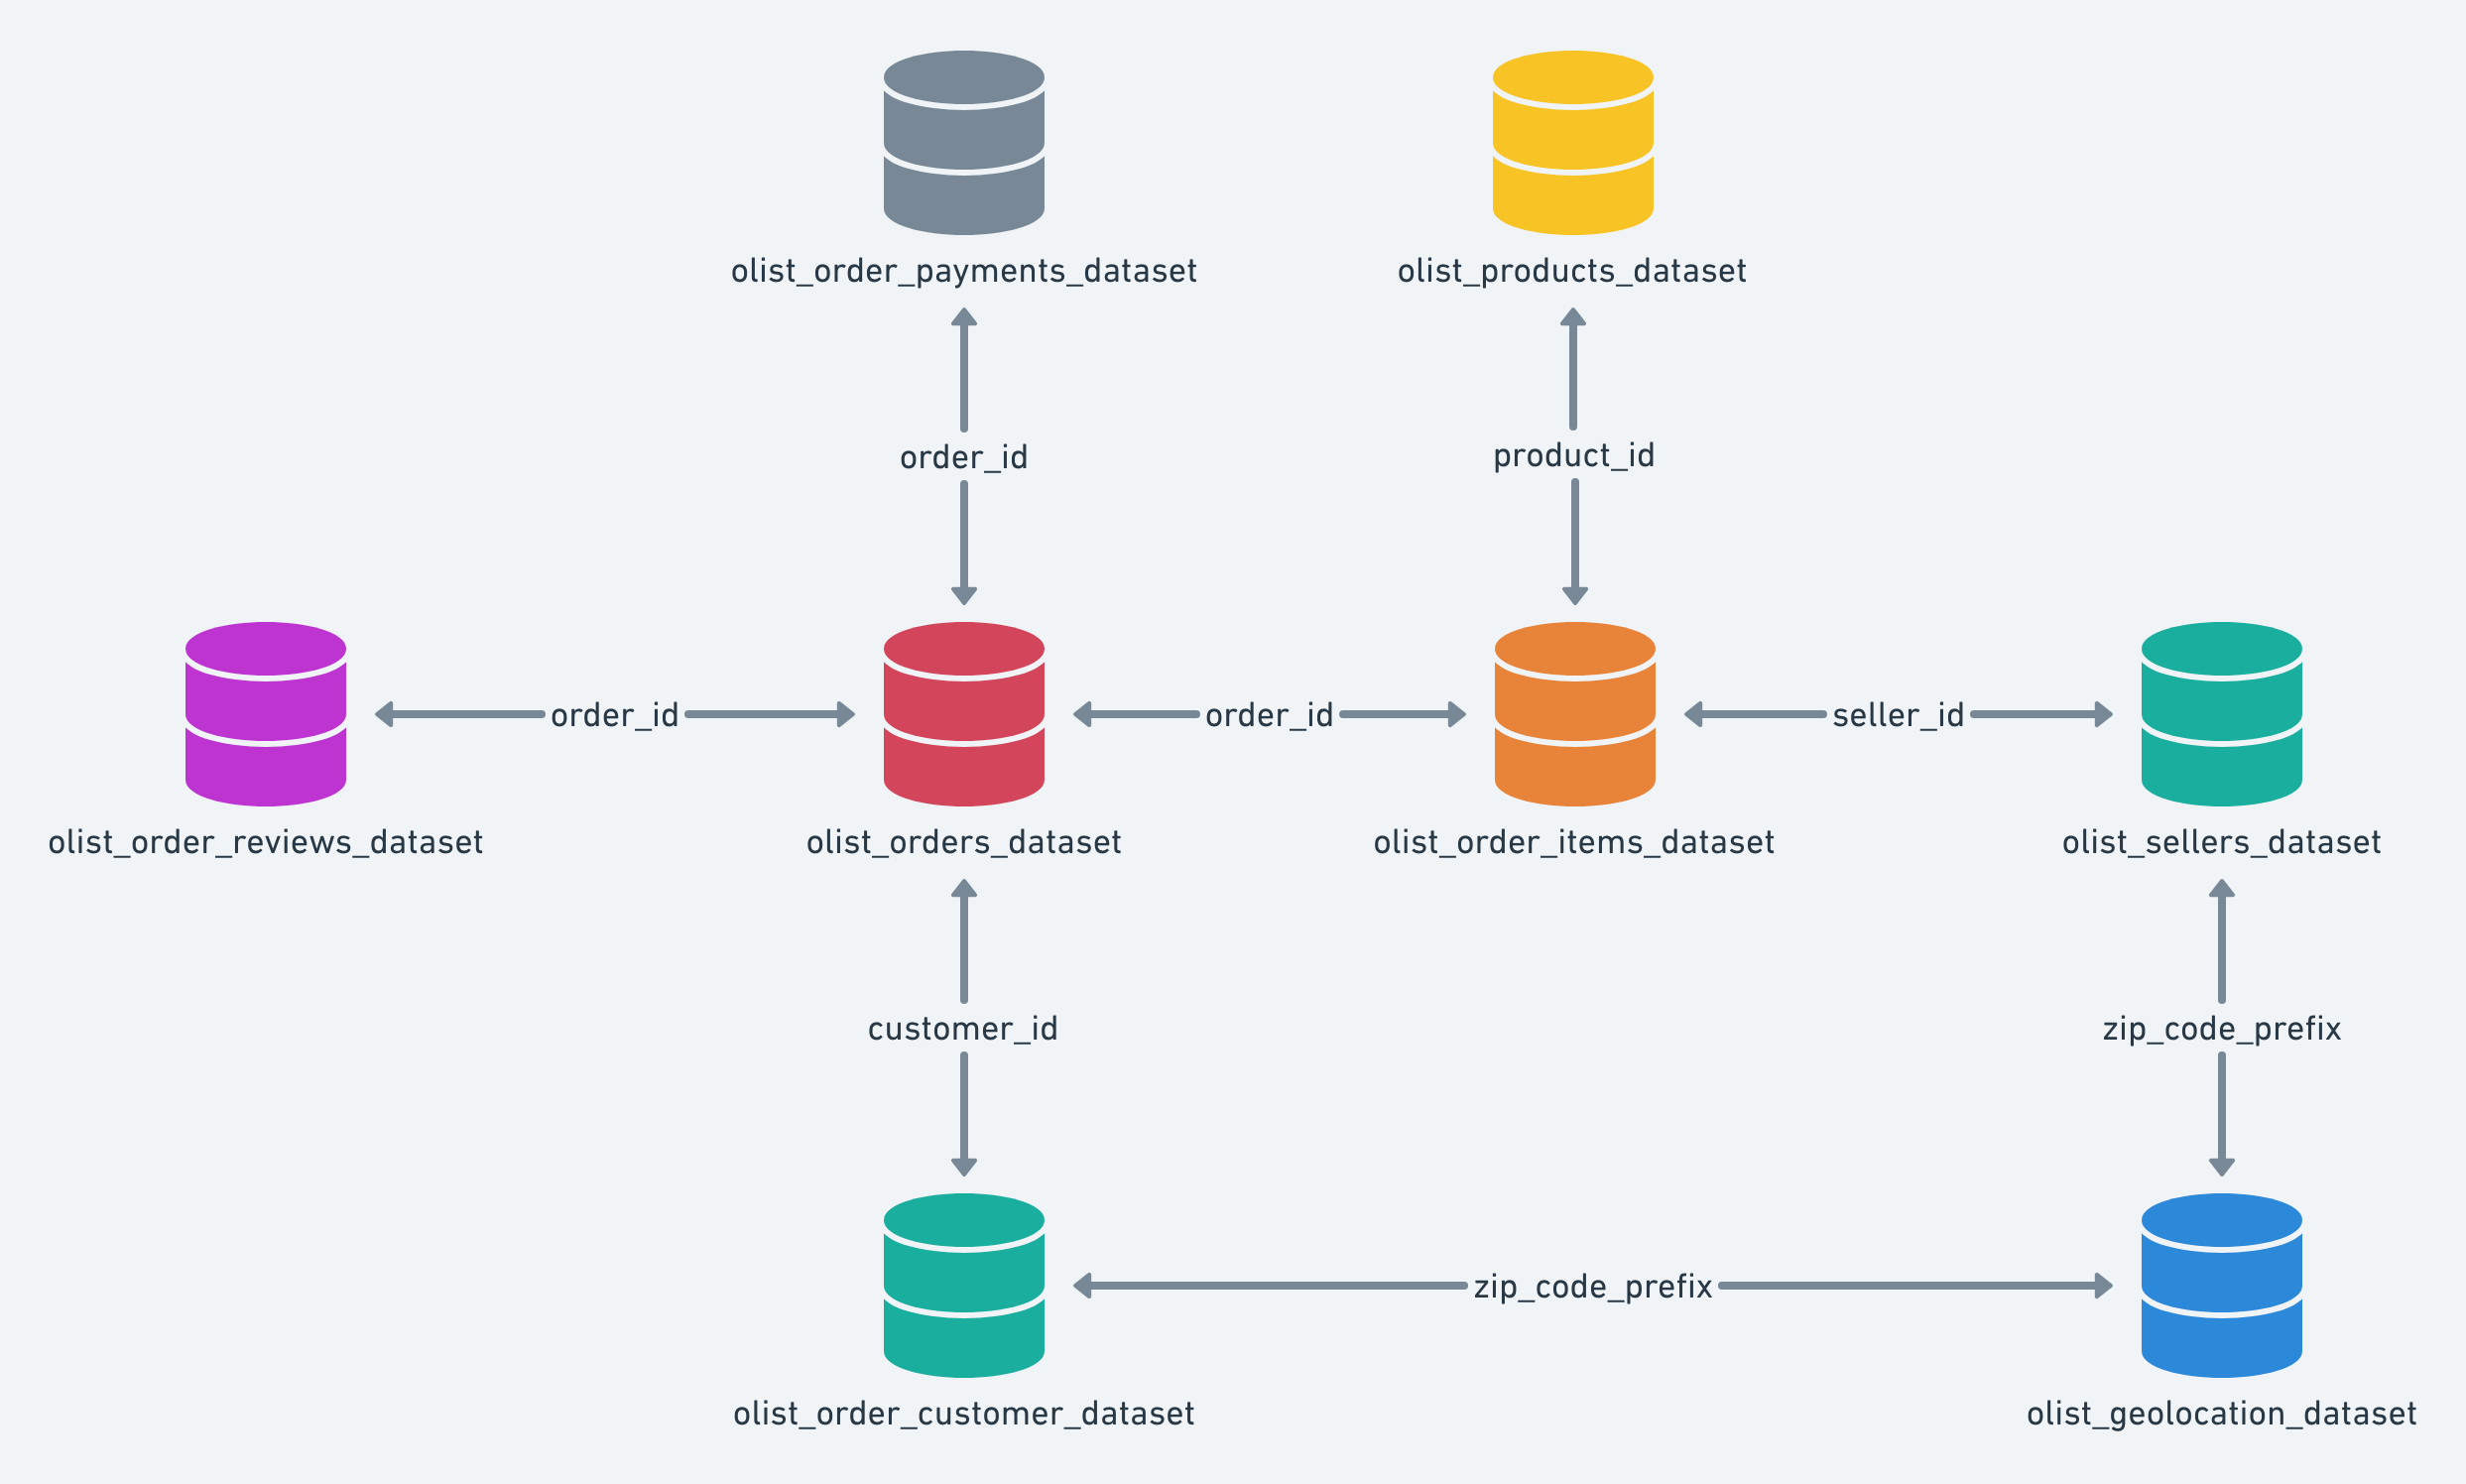

### 1.4.2. Suppression des colonnes inutiles
-suppression colonnes déjà listées + regarder distribution de zip code, city et state

In [8]:
# Suppression des colonnes listées comme à supprimer
df_products = df_products[['product_id', 'product_category_name']]

In [9]:
# Distribution des variables de localisation
for var in ['customer_zip_code_prefix',
            'customer_city',
            'customer_state']:
    print(var)
    print('-' * 20)
    print('nb val uniques: ', df_customers[var].nunique())
    print('-' * 20)
    print(df_customers[var].value_counts(dropna=True))
    print('-' * 100)

for var in ['seller_zip_code_prefix',
            'seller_city',
            'seller_state']:
    print(var)
    print('-' * 20)
    print('nb val uniques: ', df_sellers[var].nunique())
    print('-' * 20)
    print(df_sellers[var].value_counts(dropna=True))
    print('-' * 100)

customer_zip_code_prefix
--------------------
nb val uniques:  14994
--------------------
22790    142
24220    124
22793    121
24230    117
22775    110
        ... 
59820      1
47590      1
56313      1
44023      1
39113      1
Name: customer_zip_code_prefix, Length: 14994, dtype: int64
----------------------------------------------------------------------------------------------------
customer_city
--------------------
nb val uniques:  4119
--------------------
sao paulo                  15540
rio de janeiro              6882
belo horizonte              2773
brasilia                    2131
curitiba                    1521
                           ...  
rio dos cedros                 1
tabuleiro do norte             1
centro novo do maranhao        1
minduri                        1
progresso                      1
Name: customer_city, Length: 4119, dtype: int64
----------------------------------------------------------------------------------------------------
customer_state
-

In [10]:
# suppression des variables de localisation inutiles
df_customers.drop(columns=['customer_zip_code_prefix',
                           'customer_city'],
                  inplace=True)
df_sellers.drop(columns=['seller_zip_code_prefix',
                         'seller_city'],
                inplace=True)

### 1.4.3. Merge

In [11]:
# Redéfinition de la liste dfs et des noms de df
dfs = [df_customers,
       df_items,
       df_orders,
       df_payments,
       df_products,
       df_prod_cat_translation,
       df_reviews,
       df_sellers]

df_customers.name = 'df_customers'
df_items.name = 'df_items'
df_orders.name = 'df_orders'
df_payments.name = 'df_payments'
df_products.name = 'df_products'
df_prod_cat_translation.name = 'df_prod_cat_translation'
df_reviews.name = 'df_reviews'
df_sellers.name = 'df_sellers'

In [12]:
def verif (dfs):
    '''Fonction de vérification avant-après merge'''
    for df in dfs:
        print(df.name, ' shape : ', df.shape)
        print('-' * 50)
        for var in df.columns:
            print(var, ' - nb val uniques : ', df[var].nunique())
        print('-' * 50)
        for var in df.columns:
            print(var, ' - nb NaN : ', df[var].isna().sum())
        print('-' * 100)
        print('-' * 100)

In [13]:
verif(dfs)

df_customers  shape :  (99441, 3)
--------------------------------------------------
customer_id  - nb val uniques :  99441
customer_unique_id  - nb val uniques :  96096
customer_state  - nb val uniques :  27
--------------------------------------------------
customer_id  - nb NaN :  0
customer_unique_id  - nb NaN :  0
customer_state  - nb NaN :  0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_items  shape :  (112650, 7)
--------------------------------------------------
order_id  - nb val uniques :  98666
order_item_id  - nb val uniques :  21
product_id  - nb val uniques :  32951
seller_id  - nb val uniques :  3095
shipping_limit_date  - nb val uniques :  93318
price  - nb val uniques :  5968
freight_value  - nb val uniques :  6999
--------------------------------------------------
order_id  - nb NaN :  0
order_item_id  - nb NaN

#### 1.4.3.1. Traduction des catégories de produits : merge de df_products et df_prod_cat_translation

In [14]:
# Merge des deux df
df_products2 = pd.merge(df_products, df_prod_cat_translation,
                        how='left')

# Remplacement des NaN de product_category_name_english 
# par les valeurs de product_category_name
df_products2.product_category_name_english \
    .fillna(df_products2.product_category_name,
            inplace = True)

# Suppression de la colonne initiale
df_products2.drop(columns=['product_category_name'],
                  inplace=True)

# Verifications
df_products2.name = 'df_products2'
verif([df_products2, df_products, df_prod_cat_translation])

df_products2  shape :  (32951, 2)
--------------------------------------------------
product_id  - nb val uniques :  32951
product_category_name_english  - nb val uniques :  73
--------------------------------------------------
product_id  - nb NaN :  0
product_category_name_english  - nb NaN :  610
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_products  shape :  (32951, 2)
--------------------------------------------------
product_id  - nb val uniques :  32951
product_category_name  - nb val uniques :  73
--------------------------------------------------
product_id  - nb NaN :  0
product_category_name  - nb NaN :  610
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_prod_cat

In [15]:
# On renomme la colonne:
df_products2.rename(columns={'product_category_name_english':'product_category'},
                   inplace=True)

#### 1.4.3.2. Autres merges
L'idée est de garder un max de lignes, mais il faudra faire attention avec l'utilisation des aggfunc lors de la création des données groupées par customer_unique_id car certaines infos seront redondantes

In [16]:
# Redéfinition de la liste dfs et des noms de df
dfs = [df_customers,
       df_items,
       df_orders,
       df_payments,
       df_products2,
       df_prod_cat_translation,
       df_reviews,
       df_sellers]

df_customers.name = 'df_customers'
df_items.name = 'df_items'
df_orders.name = 'df_orders'
df_payments.name = 'df_payments'
df_products2.name = 'df_products2'
df_prod_cat_translation.name = 'df_prod_cat_translation'
df_reviews.name = 'df_reviews'
df_sellers.name = 'df_sellers'

**==> Merge des infos produits**

In [17]:
# Merge des df
merged_products = pd.merge(pd.merge(df_items, df_products2,
                                    on='product_id',
                                    how='left'),
                           df_sellers,
                           on='seller_id',
                           how='left')

# Verif
merged_products.name = 'merged_products'
verif([merged_products, df_items, df_products2, df_sellers])    

merged_products  shape :  (112650, 9)
--------------------------------------------------
order_id  - nb val uniques :  98666
order_item_id  - nb val uniques :  21
product_id  - nb val uniques :  32951
seller_id  - nb val uniques :  3095
shipping_limit_date  - nb val uniques :  93318
price  - nb val uniques :  5968
freight_value  - nb val uniques :  6999
product_category  - nb val uniques :  73
seller_state  - nb val uniques :  23
--------------------------------------------------
order_id  - nb NaN :  0
order_item_id  - nb NaN :  0
product_id  - nb NaN :  0
seller_id  - nb NaN :  0
shipping_limit_date  - nb NaN :  0
price  - nb NaN :  0
freight_value  - nb NaN :  0
product_category  - nb NaN :  1603
seller_state  - nb NaN :  0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
df_items  shape :  (112650, 7)
------------------------------

Le merge apparaît être correct.

**==> Merge des infos de commandes (hors produits)**

In [18]:
# Merge des df
merged_orders = pd.merge(pd.merge(pd.merge(df_payments, df_orders,
                                           on='order_id',
                                           how='right'),
                                  df_customers,
                                  on='customer_id',
                                  how='left'),
                         df_reviews, 
                         on='order_id',
                         how='left')

# Verif
merged_orders.name = 'merged_orders'
verif([merged_orders,
       df_payments,
       df_orders,
       df_customers,
       df_reviews])  

merged_orders  shape :  (104486, 20)
--------------------------------------------------
order_id  - nb val uniques :  99441
payment_sequential  - nb val uniques :  29
payment_type  - nb val uniques :  5
payment_installments  - nb val uniques :  24
payment_value  - nb val uniques :  29077
customer_id  - nb val uniques :  99441
order_status  - nb val uniques :  8
order_purchase_timestamp  - nb val uniques :  98875
order_approved_at  - nb val uniques :  90733
order_delivered_carrier_date  - nb val uniques :  81018
order_delivered_customer_date  - nb val uniques :  95664
order_estimated_delivery_date  - nb val uniques :  459
customer_unique_id  - nb val uniques :  96096
customer_state  - nb val uniques :  27
review_id  - nb val uniques :  99173
review_score  - nb val uniques :  5
review_comment_title  - nb val uniques :  4600
review_comment_message  - nb val uniques :  36921
review_creation_date  - nb val uniques :  637
review_answer_timestamp  - nb val uniques :  99010
-------------------

*--> infos de paiement manquante pour 1 ligne -- correspond à l'order_id non référencé dans df_payments*

In [19]:
merged_orders[merged_orders.payment_sequential.isna() == True]

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
32308,bfbd0f9bdef84302105ad712db648a6c,NaN,NaN,NaN,NaN,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,830d5b7aaa3b6f1e9ad63703bec97d23,SP,6916ca4502d6d3bfd39818759d55d536,1,NaN,nao recebi o produto e nem resposta da empresa,2016-10-06,2016-10-07 18:32:28


In [20]:
df_payments[df_payments.order_id == 'bfbd0f9bdef84302105ad712db648a6c']

,order_id,payment_sequential,payment_type,payment_installments,payment_value


Il s'agit sans doute d'un client non satisfait qui a renvoyé son produit (car notifié 'delivered') et s'est fait remboursé.

_**Remarque:**_

*l'augmentation du nb de lignes de merged_orders se fait à la dernière (3eme) étape de merge (df_reviews sur le reste) car il y a parfois plusieurs reviews par commande (un meme order_id a plusieurs reviews)*

Le merge semble correct.

**==> Merge final : df infos produits avec df infos commandes**

In [21]:
# Merge des df
merged_df = pd.merge(merged_orders, merged_products,
              on='order_id',
              how='left')

# Verif
merged_df.name = 'merged_df'
verif([merged_df, merged_orders, merged_products])   

merged_df  shape :  (119151, 28)
--------------------------------------------------
order_id  - nb val uniques :  99441
payment_sequential  - nb val uniques :  29
payment_type  - nb val uniques :  5
payment_installments  - nb val uniques :  24
payment_value  - nb val uniques :  29077
customer_id  - nb val uniques :  99441
order_status  - nb val uniques :  8
order_purchase_timestamp  - nb val uniques :  98875
order_approved_at  - nb val uniques :  90733
order_delivered_carrier_date  - nb val uniques :  81018
order_delivered_customer_date  - nb val uniques :  95664
order_estimated_delivery_date  - nb val uniques :  459
customer_unique_id  - nb val uniques :  96096
customer_state  - nb val uniques :  27
review_id  - nb val uniques :  99173
review_score  - nb val uniques :  5
review_comment_title  - nb val uniques :  4600
review_comment_message  - nb val uniques :  36921
review_creation_date  - nb val uniques :  637
review_answer_timestamp  - nb val uniques :  99010
order_item_id  - nb val

In [22]:
# Visualisation du df mergé final
pd.set_option('display.max_columns', 28)
merged_df

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,credit_card,1.0,18.12,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,SP
1,e481f51cbdc54678b7cc49136f2d6af7,3.0,voucher,1.0,2.00,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,SP
2,e481f51cbdc54678b7cc49136f2d6af7,2.0,voucher,1.0,18.59,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,housewares,SP
3,53cdb2fc8bc7dce0b6741e2150273451,1.0,boleto,1.0,141.46,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,BA,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumery,SP
4,47770eb9100c2d0c44946d9cf07ec65d,1.0,credit_card,3.0,179.12,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,GO,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18,2018-08-22 19:07:58,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,auto,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119146,63943bddc261676b46f01ca7ac2f7bd8,1.0,credit_card,3.0,195.00,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,SP,29bb71b2760d0f876dfa178a76bc4734,4,NaN,So uma peça que veio rachado mas tudo bem rs,2018-03-01,2018-03-02 17:50:01,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,baby,SP
119147,83c1379a015df1e13d02aae0204711ab,1.0,credit_card,5.0,271.01,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,BA,371579771219f6db2d830d50805977bb,5,NaN,Foi entregue antes do prazo.,2017-09-22,2017-09-22 23:10:57,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,home_appliances_2,SP
119148,11c177c8e97725db2631073c19f07b62,1.0,credit_card,4.0,441.16,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157b

In [10]:
# Visualisations de qq individus particuliers 
# pour comprendre les spécifités du merge 
# et les précautions à prendre par la suite
test = merged_df[merged_df.order_item_id == 4]
test = test[test.payment_sequential == 3]
test

In [11]:
merged_df[merged_df.customer_unique_id == '69aedec762e21e5aaca6eba2e635dcfb']

# 2. Nettoyage
- NaN et NaT
- valeurs aberrantes
- outliers
- recatégorisation homogénéisée puis simplifiée

## 2.1. Traitement des NaN et NaT

### 2.1.1. payment_sequential/payment_type/payment_installments/payment_value  - nb NaN :  3

In [1]:
# Visualisation des individus avec ces NaN
merged_df[merged_df.payment_sequential.isna() == True]

In [2]:
# Exploration de la raison de ces NaN
# à travers la review laissée par le client
df_reviews[df_reviews.review_id == '6916ca4502d6d3bfd39818759d55d536']

In [3]:
# Exploration de l'activité globale de ce client sur olist
merged_df[merged_df.customer_unique_id == '830d5b7aaa3b6f1e9ad63703bec97d23']

In [4]:
# NaN sur payment_value : exploration des individus
# dont payment_value == 0 pour voir si comblement 0 possible
merged_df[merged_df.payment_value == 0]

- les 3 NaN correspondent au même client / à la même commande : commande de 3 articles non livrée dans les délais (mais beaucoup plus tard)
- les NaN sont apparues lors du merge (order_id non existant dans df_payments)
- ce client n'a pas passé d'autres commandes, ni  avant ni après

**==> Comblement:**
- payment_sequential, payment_type, payment_installments : classe/valeur la plus fréquente
- payment_value: (price	+ freight_value) pour chaque ligne si payment_sequential == 1, SINON si payment_sequential == *n* alors comblement par (price	+ freight_value)/*n* pour chaque ligne  -- en effet, payment_value = montant total de la commande, identique pour chaque ligne correspondant chacune à un article ou correspondant chacune à un échellonnement, différent seulement pour chaque ligne correspondant chacune à un payment_sequential) - /// pas de comblement par 0 car payment_value == 0 pour commandes non validées/finalisées (i.e. mise au panier mais commande non effectuée au final) et pour paiement via certains vouchers

In [31]:
# Comblement des NaN par valeur la plus fréquente:
merged_df['payment_sequential'].fillna(merged_df['payment_sequential']\
                                       .mode()[0], inplace = True)
merged_df['payment_type'].fillna(merged_df['payment_type']\
                                 .mode()[0], inplace = True)
merged_df['payment_installments'].fillna(merged_df['payment_installments']\
                                         .mode()[0], inplace = True)

In [12]:
# Vérif si comblement NaN payment_sequential == 1 ou non:
merged_df[merged_df.customer_unique_id == '830d5b7aaa3b6f1e9ad63703bec97d23']

In [33]:
# comblement NaN payment_sequential == 1 donc comblement NaN payment_value par (price + freight_value) pour chaque ligne
merged_df['payment_value'].fillna(merged_df.price + merged_df.freight_value,
                                  inplace = True)

In [13]:
# Vérification
merged_df[merged_df.customer_unique_id == '830d5b7aaa3b6f1e9ad63703bec97d23']

### 2.1.2. order_approved_at  - nb NaN :  177

In [5]:
# Visualisation des individus avec ces NaN
pd.set_option('display.max_rows', 177)
merged_df[merged_df.order_approved_at.isna() == True]

Ces NaT semblent correspondre à des order_status == 'canceled', 'created' OU 'delivered', et non pas à des mises au panier non finalisées

In [6]:
merged_df[merged_df.order_status == 'canceled']

In [7]:
merged_df[merged_df.order_status == 'created']

In [8]:
test = merged_df[merged_df.order_approved_at.isna() == True]
test[test.order_status == 'delivered']

In [39]:
# date la plus récente
max(max(merged_df.order_purchase_timestamp),
    max(merged_df.order_approved_at),
    max(merged_df.order_delivered_carrier_date),
    max(merged_df.order_delivered_customer_date))

Timestamp('2018-10-17 17:30:18')

- Les NaT associées à 'created' comme à 'canceled' correspondent à des annulations pour raisons diverses (achat non livré dans les temps, insatisfaction, échange...)... et non à des commandes non finalisées après mise au panier.

- Les NaT associées à 'delivered' correspondent à des achats effectués sur les mêmes périodes (2 périodes), et donc à mon avis à des bugs.

> **==> Comblement NaN** : dans les 2 cas, on peut remplacer les NaT par order_purchase_timestamp + t où t = temps moyen entre order_purchase_timestamp et order_approved_at

In [40]:
# Calcul de ce temps t moyen

    # sur df sans les NaN de order_approved_at
test = merged_df[merged_df.order_approved_at.notna()]

print(test.order_approved_at.nunique()) # pour verif
print(test.order_id.nunique()) # pour verif
print(test.customer_id.nunique()) # pour verif

    # et sur données restreintes pour ne pas avoir de doublons 
test = test[test.payment_sequential == 1]
test = test[test.order_item_id == 1]
# Remarque : pas besoin de restreindre sur les payment_installments car pas de doublons de lignes lorsque > 1

print(test.order_approved_at.nunique()) # pour verif
print(test.order_id.nunique()) # pour verif
print(test.customer_id.nunique()) # pour verif


test = test[['order_purchase_timestamp','order_approved_at']].dropna()
mean_t = (test.order_approved_at - test.order_purchase_timestamp)\
    .mean(axis=0)# / pd.Timedelta(1, 'ns')
print(mean_t)

90733
99281
99281
90110
98573
98573
0 days 10:19:15.796124242


Il y a une différence sur le nb de valeurs uniques avant/après restriction du df qui n'est pas normale... tentons une autre approche pour comprendre d'où cela vient

In [14]:
# Autre approche: groupby('order_id')
test = merged_df[merged_df.order_approved_at.notna()]\
    .sort_values('payment_sequential', ascending=True)\
    .groupby('order_id').first()
test = pd.DataFrame(test)
test

In [42]:
# Verif
print(test.order_approved_at.nunique())
print(test.customer_id.nunique())
    # On a bien ici les mêmes valeurs uniques qu'avant retsrictions

90733
99281


In [43]:
# Exploration de la cause du problème : payment_sequential ???
test.payment_sequential.unique().tolist()

[1.0, 2.0]

In [9]:
test[test.payment_sequential == 2]

In [15]:
merged_df[merged_df.order_id == '056c68d093c100017aab1f00f260705c']

<span style="color:red"> **/!\ Il y a donc des commandes pour lesquelles payment_sequential n'est jamais égal à 1 !!!!!!** </span> ==> valeurs aberrantes à corriger

In [46]:
# export liste des individus sur lesquels il faudra corriger ces valeurs aberrantes
abb_val_payment_seq = test[test.payment_sequential == 2].index.tolist()

In [47]:
# nb de commandes concernées =
len(abb_val_payment_seq)
 # --> nb insuffisant pour expliquer toute la cause du problème

80

In [48]:
# Exploration de la cause du problème (2) : order_item_id ???
    # groupby('order_id') mais avec tri sur order_item_id
test = merged_df[merged_df.order_approved_at.notna()]\
    .sort_values('order_item_id', ascending=True)\
    .groupby('order_id').first()
test = pd.DataFrame(test)

In [49]:
# Verif
print(test.order_approved_at.nunique())
print(test.customer_id.nunique())
    # On a ici aussi bien les mêmes valeurs uniques qu'avant retsrictions

90733
99281


In [50]:
test.order_item_id.unique().tolist()

[1.0, nan]

In [51]:
test.order_item_id.value_counts(dropna=False)

1.0    98652
NaN      629
Name: order_item_id, dtype: int64

In [52]:
# Différence due aux valeurs aberrantes sur payment_sequential (80) 
# et aux NaN sur order_item_id (629) (-1 valeur commune aux deux)
print('différence expliquée : ', 629 + 80 - 1)

# différence entre les deux appproches
print('différence à expliquer : ', 99281-98573)

différence expliquée :  708
différence à expliquer :  708


In [53]:
# Maintenant qu'on sait d'où venait le problème, on peut calculer le temps moyen t sur le bon df... :
test = test[['order_purchase_timestamp','order_approved_at']]\
    .dropna()
mean_t = (test.order_approved_at - test.order_purchase_timestamp)\
    .mean(axis=0).round('s')
print(mean_t)

0 days 10:25:09


In [54]:
# ... puis corriger nos NaT sur order_approved_at par order_purchase_timestamp + t où t = mean_t
print('nb NaT sur order_approved_at AVANT comblement : ',\
          merged_df[merged_df.order_approved_at.isna() == True]\
          .shape[0])
merged_df['order_approved_at'].\
    fillna(merged_df.order_purchase_timestamp + mean_t,
           inplace = True)
print('nb NaT sur order_approved_at APRES comblement : ',\
          merged_df[merged_df.order_approved_at.isna() == True]\
          .shape[0])

nb NaT sur order_approved_at AVANT comblement :  177
nb NaT sur order_approved_at APRES comblement :  0


### 2.1.3. order_delivered_carrier_date  - nb NaN :  2086

In [55]:
# colonne non nécessaire au clustering

### 2.1.4. order_delivered_customer_date  - nb NaN :  3421

In [56]:
# colonne non nécessaire au clustering: 
# si client insatisfait des délais de livraison,
# cela apparaitra dans le score de review

### 2.1.5. order_item_id / product_id  / seller_id / shipping_limit_date / price / freight_value / seller_state  - nb NaN :  833

In [16]:
# Visualisation des individus
pd.set_option('display.max_rows', 833)
merged_df[merged_df.order_item_id.isna()==True]

In [58]:
# nombre d'order_id unique associées
merged_df[merged_df.price.isna()==True].order_id.nunique()

775

In [59]:
# Certains order_id se retrouvent plusieurs fois
merged_df[merged_df.price.isna()==True].order_id.value_counts()[0:20]

48f2d0b950703bfb145b7c3c0641b4bb    10
0b398dbb3e7c81005f3c69b01488c4c9     9
896fbd78a9ef3839b34b893f48f6bc67     8
1857e77a4bad8abb2db929f107430663     6
b34369ee8397436dd7ceb8bb7783671d     4
59798edc300f7563a9bdf18b2740def9     4
cdf36cd4632fe33085adec5cf3d6b306     3
4b460251c3d2ba44dd61b0b6c3410ac6     2
4317fe882d992cda2fb3d51baeb2751c     2
04b8c60eb3cceaecde917716daa30bde     2
f8303e6eff198d1749d04649a1eb2bb6     2
85a22eb264ad44ff56c4955a66876fed     2
6900ba78f72feb30643f7c2e2ebb3aa1     2
2429083883078c31cf2337ce0dd425ee     2
02e723e8edb4a123d414f56cc9c4665e     2
9eb45b0aa6ff6baf71a20c68414f8089     2
20ff9b4b339b20ef47cfcda736a17a52     2
50bb0c134ee3365dd06e13da6cda15fe     2
6ec704c9a120baaa6b3e162255ec684b     2
1c7c8ab324927f5b6e52338bd110bef4     2
Name: order_id, dtype: int64

In [17]:
# C'est lié au nombre de payment_sequential
merged_df[merged_df.order_id == '48f2d0b950703bfb145b7c3c0641b4bb']

In [61]:
# Toutes ces NaN sont-elles liées à des clients non satisfaits ('order_status' == 'canceled') 
    # ou à des commandes en cours ('order_status' == 'unavailable') ???
merged_df[merged_df.order_item_id.isna()==True].order_status.value_counts()

unavailable    645
canceled       180
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

Remarque: les order_status semblent de mauvaise qualité, du moins une feature de mauvaise qualité pour le clusturing: 
- 'created' concerne des commandes hors délai
- 'cancelled' concerne aussi bien des avis positifs que négatifs
- 'unavailable' concerne... difficile à dire
- le 'shipped' et les 2 'invoiced' concernent ici une commande datant de 2016

Ajout à la liste des colonnes à supprimer:

In [62]:
# Difficile d'expliquer les NaN ici...
# On va donc combler de manière générique les NaN des features utiles, i.e.: 
    # order_item_id --> remplacement par valeur la plus fréquente ou moyenne??
    # price / freight_value --> à partir de payment_value et ratio moyen entre prix et
        # frais de port par article (prendre en compte valeur de order_item_id remplaçant NaN)
    # seller_state --> remplacement par 'unknown'
# et ne rien faire sur les autres features

- **order_item_id --> remplacement par valeur la plus fréquente ou moyenne**

In [18]:
# création du df nécessaire au calcul de order_item_id moyen / le plus fréquent
test = merged_df[merged_df.order_item_id.notna()]\
    .sort_values('order_item_id', ascending=True)\
    .groupby('order_id').last()
test = pd.DataFrame(test)
test.order_item_id.unique().tolist()

In [64]:
# calcul de order_item_id moyen / le plus fréquent
mean_item_id = round(test.order_item_id.mean(),1)
print('mean_item_id = ', mean_item_id)
most_freq_item_id = test.order_item_id.mode()[0]
print('most_freq_item_id = ', most_freq_item_id)

mean_item_id =  1.1
most_freq_item_id =  1.0


In [65]:
# On va remplacer par la valeur moyenne (comme elle n'est pas ronde mais reste proche de 1, 
# cela permettra d'identifier rapidement les NaN remplacées ici tout en restant proche de la valeur la + fréquente)

# verif avant remplacement:
print('nb NaN order_item_id AVANT remplacement : ', \
    merged_df[merged_df.order_item_id.isna() == True].shape[0])
# Remplacement NaN:
merged_df.order_item_id.fillna(mean_item_id, inplace=True)
# verif après remplacement:
print('nb NaN order_item_id APRES remplacement : ', \
    merged_df[merged_df.order_item_id.isna() == True].shape[0])
print('nb val de order_item_id égales à mean_item_id : ', \
    merged_df[merged_df.order_item_id == mean_item_id].shape[0])

nb NaN order_item_id AVANT remplacement :  833
nb NaN order_item_id APRES remplacement :  0
nb val de order_item_id égales à mean_item_id :  833


- **price / freight_value --> à partir de payment_value et ratio moyen entre prix et frais de port par article**

(prendre en compte valeur de order_item_id remplaçant NaN --> c'est (environ) 1 donc pas besoin de répartir le payment_value sur plusieurs articles)

In [19]:
# Pourrait-on grouper sur les product_id ??
    # --> Visualisation du produit le plus vendu pour déterminer comment
merged_df[merged_df.product_id == merged_df.product_id.mode()[0]]

In [67]:
# création du df nécessaire au calcul du ratio moyen
# entre prix et frais de port par article
    # restriction aux commandes avec un seul article 
    # (sinon, i.e. avec un simple groupby('product_id').mean(),
    # payment_value != price + freight_value
    # pour commandes avec plusieurs articles
    # et cela fausse le résultat, i.e. sum != 1)
test = merged_df[merged_df.payment_value == 
                 merged_df.price + merged_df.freight_value] \
    .groupby('product_id').mean()

# calcul du ratio moyen entre prix et frais de port par article
mean_ratio_price = round(
    test.price.mean() / test.payment_value.mean(),2)
print('mean_ratio_price = ', mean_ratio_price)
mean_ratio_freight = round(
    test.freight_value.mean() / test.payment_value.mean(), 2)
print('mean_ratio_freight = ', mean_ratio_freight)

print('sum = ', mean_ratio_freight + mean_ratio_price)

mean_ratio_price =  0.88
mean_ratio_freight =  0.12
sum =  1.0


In [68]:
# Définition des listes des commandes
    # sur lesquelles combler les NaN de price et freight_value
order_id_to_clean = merged_df[merged_df.freight_value.isna()==True] \
    .order_id.unique().tolist()
    # versus toutes les autres
order_id_others = merged_df[~merged_df.freight_value.isna()==True] \
    .order_id.unique().tolist()

# verif avant comblement NaN
print('moyenne price others AVANT correction = ',
      merged_df[merged_df.order_id.isin(order_id_others)]\
      .price.mean())
print('moyenne freight_value others AVANT correction = ',
      merged_df[merged_df.order_id.isin(order_id_others)]\
      .freight_value.mean())
print('nb NaN freight_value = ',
      merged_df[merged_df.freight_value.isna()==True]\
      .shape[0])
print('nb NaN price = ',
      merged_df[merged_df.price.isna()==True].shape[0])

# Comblement
for order_id in order_id_to_clean:
    montant_total = merged_df[merged_df.order_id == order_id] \
        .groupby('order_id').payment_value.sum()
    merged_df['price'] = np.where(merged_df.order_id == order_id,
                                  mean_ratio_price * montant_total,
                                  merged_df['price'])
    merged_df['freight_value'] = np.where(merged_df.order_id == order_id,
                                          mean_ratio_freight * montant_total,
                                          merged_df['freight_value'])

# Vérif après comblement
print('-' * 40)
print('moyenne price others APRES correction = ',
      merged_df[merged_df.order_id.isin(order_id_others)]\
      .price.mean())
print('moyenne freight_value others APRES correction = ',
      merged_df[merged_df.order_id.isin(order_id_others)]\
      .freight_value.mean())
print('nb NaN freight_value = ',
      merged_df[merged_df.freight_value.isna()==True].shape[0])
print('nb NaN price = ',
      merged_df[merged_df.price.isna()==True].shape[0])

moyenne price others AVANT correction =  120.6491085888478
moyenne freight_value others AVANT correction =  20.03258743386696
nb NaN freight_value =  833
nb NaN price =  833
----------------------------------------
moyenne price others APRES correction =  120.6491085888478
moyenne freight_value others APRES correction =  20.03258743386696
nb NaN freight_value =  0
nb NaN price =  0


In [20]:
# Verif visuelle
merged_df[merged_df.order_id.isin(order_id_to_clean)]

- **seller_state --> remplacement par 'unknown'**

In [70]:
# verif avant remplacement:
print('nb NaN seller_state AVANT remplacement : ', \
    merged_df[merged_df.seller_state.isna() == True].shape[0])

# Remplacement NaN:
merged_df.seller_state.fillna('unknown', inplace=True)

# verif après remplacement:
print('nb NaN seller_state APRES remplacement : ', \
    merged_df[merged_df.seller_state.isna() == True].shape[0])
print('nb val de seller_state égales à \'unknown\' : ', \
    merged_df[merged_df.seller_state == 'unknown'].shape[0])

nb NaN seller_state AVANT remplacement :  833
nb NaN seller_state APRES remplacement :  0
nb val de seller_state égales à 'unknown' :  833


### 2.1.6. product_category  - nb NaN :  2542

In [21]:
# Visualisation des individus concernés
merged_df[merged_df.product_category.isna() == True]

Simple remplacement par 'unknown category' après tentative 100% infructueuse de replacer les NaN par les catégories des produits ayant le même prix

In [72]:
# verif avant comblement NaN
print('nb NaN AVANT remplacement = ',
      merged_df[merged_df.product_category.isna()==True].shape[0])
print('-' * 20)
print(merged_df.product_category.value_counts()[0:10])

# Comblement
merged_df.product_category.fillna('unknown category', inplace=True)

# verif APRES comblement NaN
print('-' * 60)
print('nb NaN APRES remplacement = ',
      merged_df[merged_df.product_category.isna()==True].shape[0])
print('nb unknown category APRES remplacement = ',
      merged_df[merged_df.product_category == 'unknown category'].shape[0])
print('-' * 20)
print(merged_df.product_category.value_counts()[0:10])

nb NaN AVANT remplacement =  2542
--------------------
bed_bath_table           11990
health_beauty            10033
sports_leisure            9005
furniture_decor           8833
computers_accessories     8151
housewares                7380
watches_gifts             6213
telephony                 4726
garden_tools              4590
auto                      4400
Name: product_category, dtype: int64
------------------------------------------------------------
nb NaN APRES remplacement =  0
nb unknown category APRES remplacement =  2542
--------------------
bed_bath_table           11990
health_beauty            10033
sports_leisure            9005
furniture_decor           8833
computers_accessories     8151
housewares                7380
watches_gifts             6213
telephony                 4726
garden_tools              4590
auto                      4400
Name: product_category, dtype: int64


### 2.1.7. Bilan

In [73]:
merged_df.name = 'merged_df'
verif([merged_df])

merged_df  shape :  (119151, 28)
--------------------------------------------------
order_id  - nb val uniques :  99441
payment_sequential  - nb val uniques :  29
payment_type  - nb val uniques :  5
payment_installments  - nb val uniques :  24
payment_value  - nb val uniques :  29077
customer_id  - nb val uniques :  99441
order_status  - nb val uniques :  8
order_purchase_timestamp  - nb val uniques :  98875
order_approved_at  - nb val uniques :  90893
order_delivered_carrier_date  - nb val uniques :  81018
order_delivered_customer_date  - nb val uniques :  95664
order_estimated_delivery_date  - nb val uniques :  459
customer_unique_id  - nb val uniques :  96096
customer_state  - nb val uniques :  27
review_id  - nb val uniques :  99173
review_score  - nb val uniques :  5
review_comment_title  - nb val uniques :  4600
review_comment_message  - nb val uniques :  36921
review_creation_date  - nb val uniques :  637
review_answer_timestamp  - nb val uniques :  99010
order_item_id  - nb val

Les seules colonnes avec des NaN / NaT ne sont pas nécessaire au clustering ==> netoyage NaN / NaT OK

## 2.2. Valeurs aberrantes

### 2.2.1. payment_value == 0 // payment_type == 'not_defined'

In [22]:
# Visualisation des individus
merged_df[merged_df.payment_value == 0]

In [23]:
list = merged_df[merged_df.payment_value == 0].order_id.unique().tolist()

merged_df[merged_df.order_id.isin(list)]

In [24]:
merged_df[merged_df.payment_type == 'not_defined']

Les payment_type == 0 ne sont pas des valeurs aberrantes. Ils correspondent:
- soit à des vouchers particuliers (dans ce cas payment_type == 'voucher')
- soit à des remboursements (dans ce cas payment_type == 'not_defined')

In [77]:
# Remplacement de payment_type == 'not_defined' par 'refund'

# verif AVANT remplacement
print(merged_df.payment_type.unique().tolist())
print('nb de not_defined AVANT remplacement = ',
      merged_df[merged_df.payment_type == 'not_defined'].shape[0])

# Remplacement
merged_df.payment_type.replace('not_defined', 'refund', inplace=True)

# verif APRES remplacement
print(merged_df.payment_type.unique().tolist())
print('nb de not_defined APRES remplacement = ',
      merged_df[merged_df.payment_type == 'not_defined'].shape[0])
print('nb de refund APRES remplacement = ',
      merged_df[merged_df.payment_type == 'refund'].shape[0])

['credit_card', 'voucher', 'boleto', 'debit_card', 'not_defined']
nb de not_defined AVANT remplacement =  3
['credit_card', 'voucher', 'boleto', 'debit_card', 'refund']
nb de not_defined APRES remplacement =  0
nb de refund APRES remplacement =  3


### 2.2.2. payment_sequential == 2, à remplacer par 1 pour order_id in abb_val_payment_seq (i.e. pour commandes pour lesquelles il n'y pas de payment_sequential == 1 mais seulement et directement == 2)

In [25]:
# Visualisation des individus concernés
merged_df[merged_df.order_id.isin(abb_val_payment_seq)]

In [79]:
# Vérif AVANT remplacement
print('nombre de 2 à remplacer par 1 = ',
      merged_df[merged_df.order_id.isin(abb_val_payment_seq)]\
      .shape[0])
print('Nombre de 1 et 2 AVANT remplacement : \n',
      merged_df.payment_sequential.value_counts().iloc[0:2])

# Remplacement
merged_df.loc[merged_df['order_id'].isin(abb_val_payment_seq),
              'payment_sequential'] \
    = merged_df.loc[merged_df['order_id'].isin(abb_val_payment_seq), 
                    'payment_sequential'].replace(2,1)

# Vérif APRES remplacement
print('nombre de 1 et 2 APRES remplacement : \n',
      merged_df.payment_sequential.value_counts().iloc[0:2])

nombre de 2 à remplacer par 1 =  92
Nombre de 1 et 2 AVANT remplacement : 
 1.0    114010
2.0      3415
Name: payment_sequential, dtype: int64
nombre de 1 et 2 APRES remplacement : 
 1.0    114100
2.0      3325
Name: payment_sequential, dtype: int64


## 2.3. Outliers
--> visualisation de la distribution des variables

In [80]:
num_features = ['payment_sequential',
                'payment_installments',
                'payment_value',
                'order_item_id',
                'review_score',
                'price',
                'freight_value']

num_d_features = ['payment_sequential',
                  'payment_installments',
                  'order_item_id',
                  'review_score']

num_c_features = ['payment_value',
                  'price',
                  'freight_value']


date_features = ['order_purchase_timestamp',
                 'order_approved_at',
                 'order_estimated_delivery_date']

categ_features = ['payment_type',
                  'order_status',
                  'customer_state',
                  'product_category',
                  'seller_state']

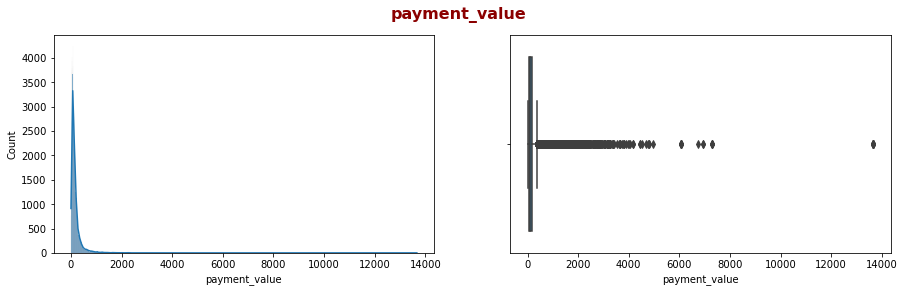

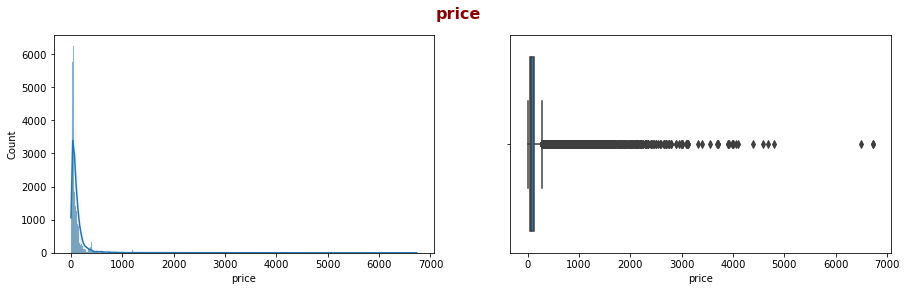

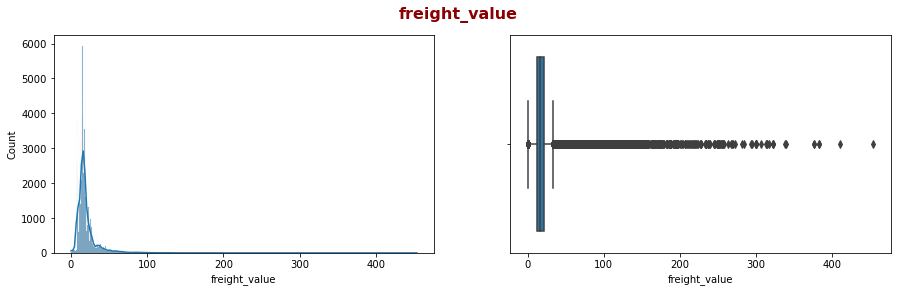

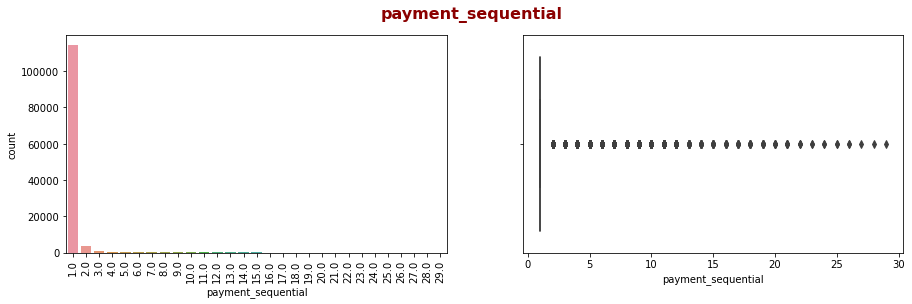

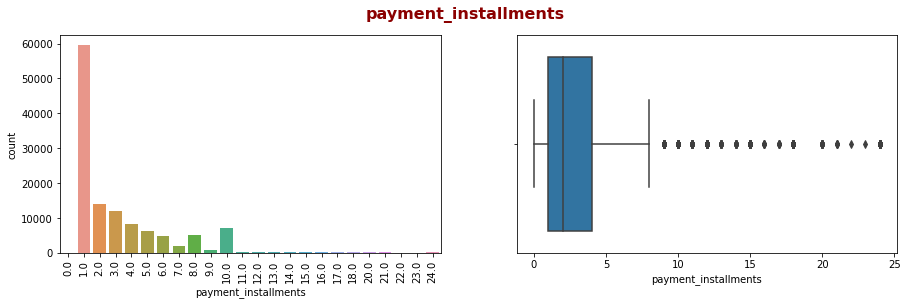

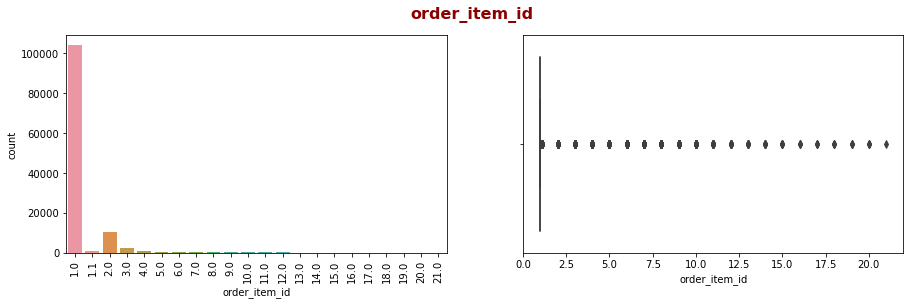

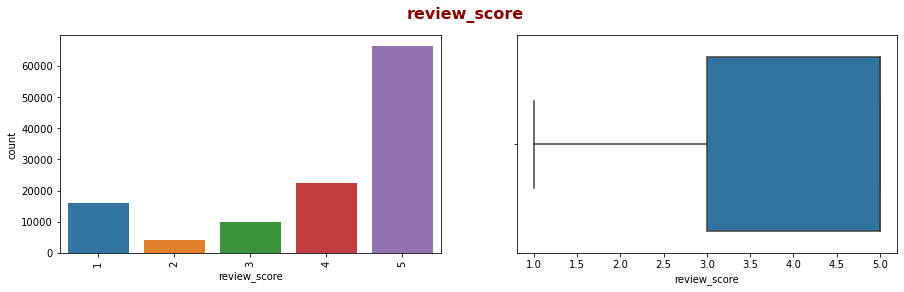

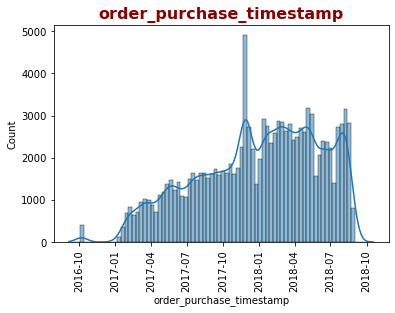

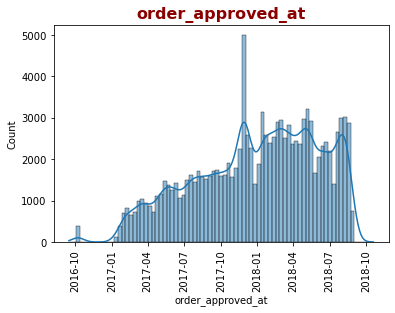

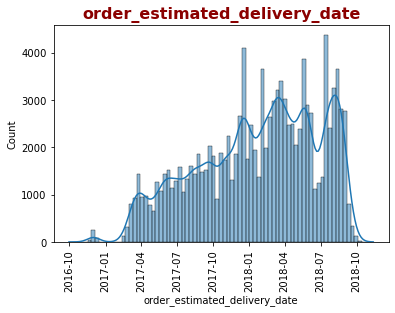

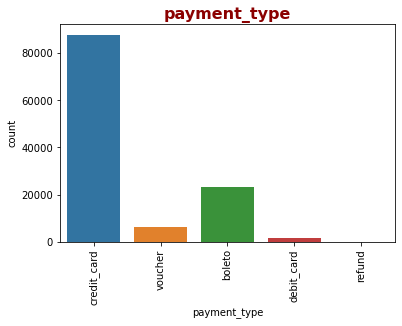

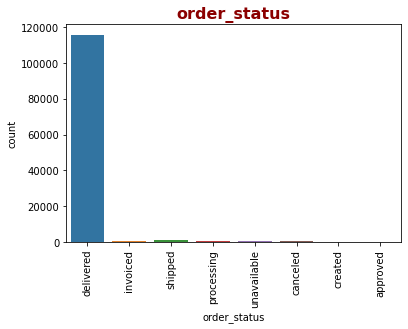

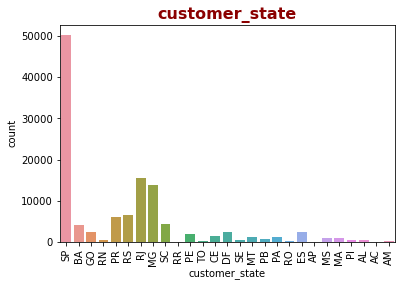

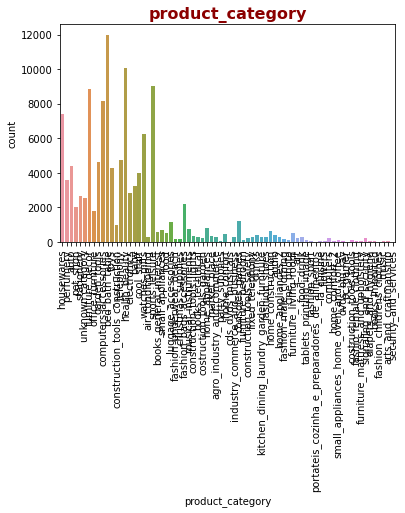

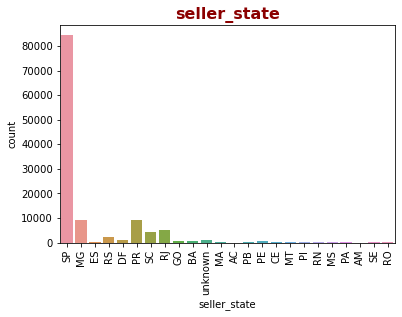

In [81]:
# Visualisation de la distribution des variables
for f in num_c_features:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f, fontsize=16, color='darkred', weight=800)
    g1 = sns.histplot(x=f, data=merged_df, kde=True, ax=axes[0])
    g2 = sns.boxplot(x=f, data=merged_df, ax=axes[1])

for f in num_d_features:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f, fontsize=16, color='darkred', weight=800)
    g1 = sns.countplot(x=f, data=merged_df, ax=axes[0])
    g1.tick_params(axis='x', rotation=90)
    g2 = sns.boxplot(x=f, data=merged_df, ax=axes[1])

for f in date_features:
    plt.figure(figsize=(6,4))
    plt.title(f, fontsize=16, color='darkred', weight=800)
    g = sns.histplot(x=f, data=merged_df, kde=True)
    g.tick_params(axis='x', rotation=90)
    
for f in categ_features:
    plt.figure(figsize=(6,4))
    plt.title(f, fontsize=16, color='darkred', weight=800)
    g = sns.countplot(x=f, data=merged_df)
    g.tick_params(axis='x', rotation=90)

### 2.3.1. payment_value, price (et freight_value)

In [26]:
merged_df[merged_df.payment_value > 6000]

**Bilan outliers payment_value, price (et freight_value):**

Bien que les valeurs extrêmes de payment_value, price (et freight_value) aient des montants élevés (max payment_value = 13664.08 real brésiliens soit environ 2200 €), elles ne semblent pas aberrantes.
On pourrait les supprimer en tant qu'outliers via 
``merged_df = merged_df[merged_df.payment_value < 6000]``
mais les très gros dépensiers étant sans doute une cible très intéressante, je préfère les laisser pour l'instant, et voir après le clustering si les supprimer pour améliorer celui-ci.

### 2.3.2. dates
supprimer les indiv dont dates anté janvier 2017??

In [27]:
# Exploration des commandes anté 2017
test = merged_df[merged_df.order_approved_at < '2017-1-1']
test

In [84]:
print('nb orders before 2017 = ',
      test.order_id.nunique())
print('% orders before 2017 = ',
      test.order_id.nunique()/merged_df.order_id.nunique())
print('start date of order_approved_at before 2017 : ',
      test.order_approved_at.min())
print('end date of order_approved_at before 2017 : ',
      test.order_approved_at.max())

nb orders before 2017 =  328
% orders before 2017 =  0.0032984382699289025
start date of order_approved_at before 2017 :  2016-09-15 12:16:38
end date of order_approved_at before 2017 :  2016-12-23 23:31:37


In [28]:
test.describe(include='all', datetime_is_numeric=True)

In [86]:
# les clients ayant passé commande avant 2017 ont-ils repassé commande après? ==> OUI
merged_df[merged_df.customer_unique_id \
    .isin(test.customer_unique_id.unique().tolist())] \
    .customer_unique_id.value_counts()[0:10]

0ecf7f65b5ff3b9e61b637e59f495e0a    8
df2988ba3ed226b10521a0e4da849b61    7
6f90ec5150be36c4475835b5941ab56f    6
5f61b10d70849d46be5643b7453e1708    6
abcee124c52c041bafc381cbc0036d24    5
880e01d45fe9fdf7f417f37e55e7730f    4
7a176e5d88c7acb6000a055e008c055d    4
4962136f755981b83b03f476e66eea7d    4
221234182f828fb9f2a4ba9c89874ede    4
854e546b53f9b86fecc634f1cc7587cb    4
Name: customer_unique_id, dtype: int64

**Bilan outliers dates :**
Là encore, je ne vais pas supprimer ces outliers potentiels dans un premier temps.

### 2.3.3. Autres variables
**==> Pas d'outliers potentiels identifiés sur les autres variables**

## 2.4. Recatégorisation homogénéisée et simplifiée

### 2.4.1. Recatégorisation de product_category

top10 categories couvrent 63 % des articles commandés
top11 categories couvrent 66 % des articles commandés
top12 categories couvrent 70 % des articles commandés
top13 categories couvrent 73 % des articles commandés
top14 categories couvrent 75 % des articles commandés
top15 categories couvrent 78 % des articles commandés
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
bed_bath_table                                   11990
health_beauty                                    10033
sports_leisure                                    9005
furniture_decor                                   8833
computers_accessories                             8151
housewares                                        7380
watches_gifts                                     6213
telephony                                         4726
garden_tools                      

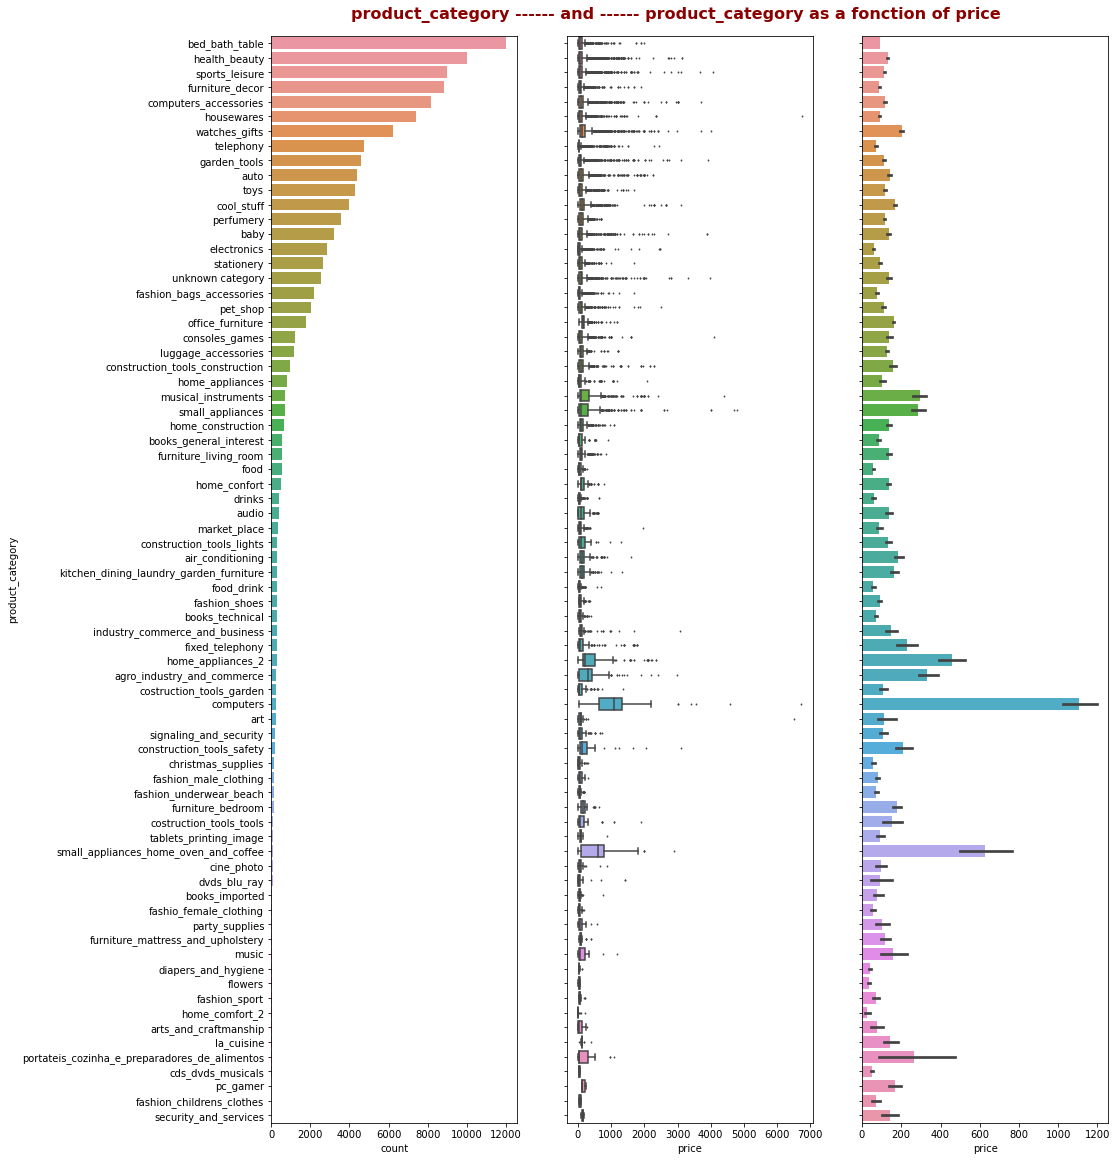

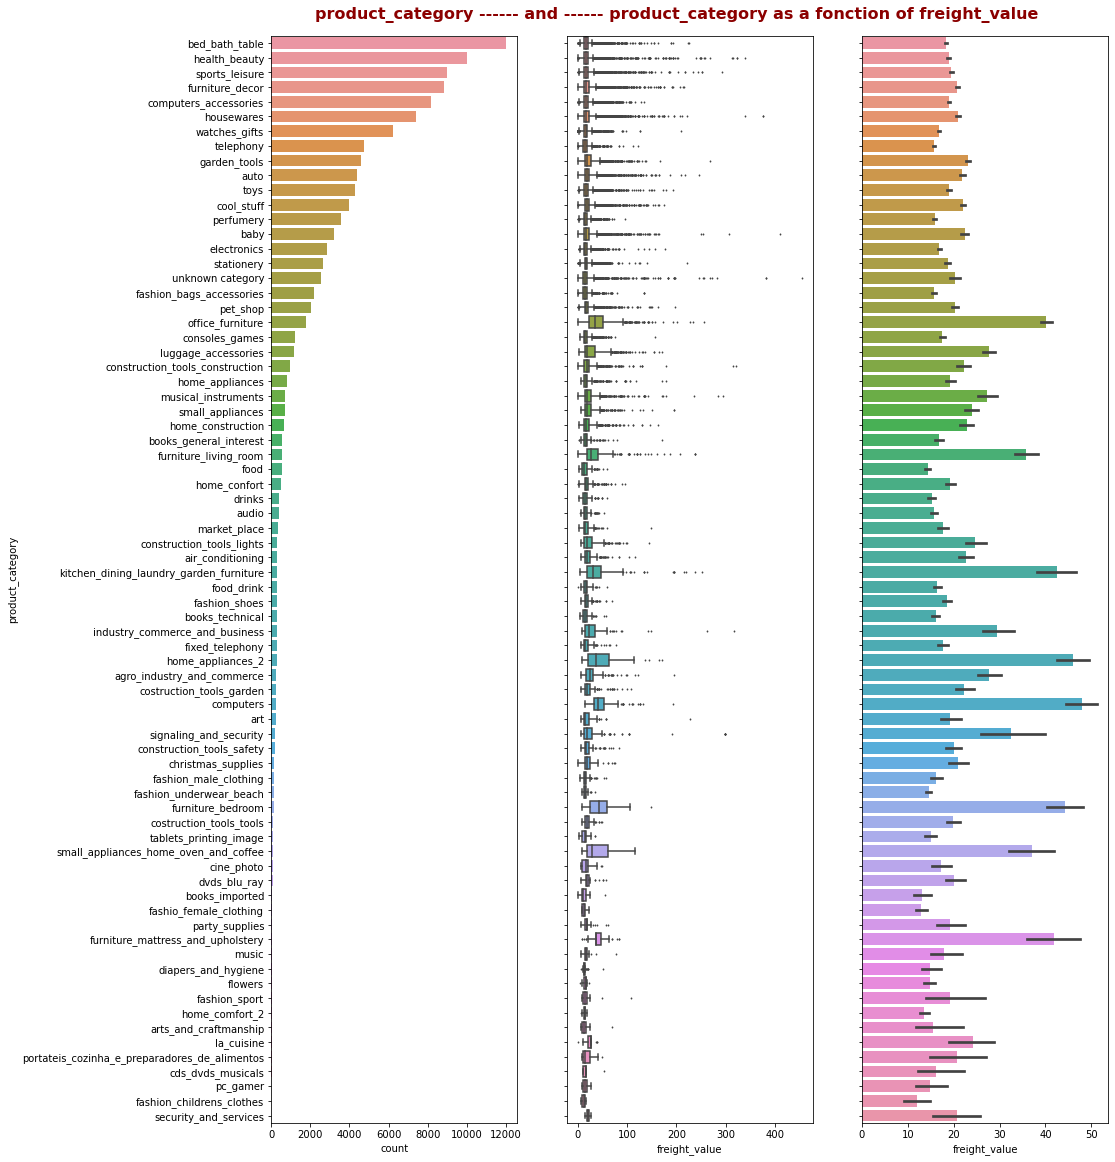

In [87]:
# Exploration de 'product_category' pour déterminer comment recatégoriser cette variable

for n in range(10,16,1):
    print('top{} categories couvrent {} % des articles commandés'\
          .format(n, int(merged_df.product_category\
                         .value_counts().cumsum()[n-1]\
                         * 100 / \
                         merged_df.product_category.value_counts().cumsum()\
                         [merged_df.product_category.nunique()-1])))

print('-' * 100)
print('-' * 100)

print(merged_df.product_category.value_counts())

print('-' * 100)
print('-' * 100)

for f in ['price', 'freight_value']:
    fig, axes = plt.subplots(1, 3, figsize=(15, 20))
    fig.suptitle('product_category ------ and ------ product_category as a fonction of {}'\
                 .format(f), y=0.9, fontsize=16, color='darkred', weight=800)
    plot_order = merged_df.product_category.value_counts().index
    # flierprops = dict(marker='o', markersize=0.5, markerfacecolor='red') #ne fonctionne que pour la taille
    g0 = sns.countplot(y='product_category',
                       data=merged_df, ax=axes[0],
                       order=plot_order)
    g1 = sns.boxplot(y='product_category', x=f,
                     data=merged_df, ax=axes[1],
                     fliersize=1, order=plot_order)
    g1.set_yticklabels([])
    g1.set_ylabel('')
    g2 = sns.barplot(y='product_category', x=f,
                     data=merged_df, ax=axes[2],
                     order=plot_order)
    g2.set_yticklabels([])
    g2.set_ylabel('')

In [88]:
# Nouvelles catégories
new_product_categories = {'home': ['bed_bath_table',
                                   'furniture_decor',
                                   'furniture_living_room',
                                   'home_confort',
                                   'kitchen_dining_laundry_garden_furniture',
                                   'furniture_bedroom',
                                   'furniture_mattress_and_upholstery',
                                   'home_comfort_2'],
                          'appliances/housewares': ['housewares',
                                                    'home_appliances',
                                                    'small_appliances',
                                                    'home_appliances_2',
                                                    'small_appliances_home_oven_and_coffee',
                                                    'air_conditioning',
                                                    'portateis_cozinha_e_preparadores_de_alimentos',
                                                    'la_cuisine'],
                          'health/beauty': ['health_beauty',
                                            'perfumery'],
                          'leisure/culture': ['sports_leisure',
                                              'books_imported',
                                              'books_technical',
                                              'books_general_interest',
                                              'musical_instruments',
                                              'audio',
                                              'cds_dvds_musicals',
                                              'music',
                                              'consoles_games',
                                              'cine_photo',
                                              'dvds_blu_ray',
                                              'arts_and_craftmanship',
                                              'art',
                                              'christmas_supplies',
                                              'party_supplies'],
                          'electronics': ['telephony',
                                          'fixed_telephony',
                                          'pc_gamer',
                                          'computers_accessories',
                                          'electronics',
                                          'computers',
                                          'tablets_printing_image'],
                          'auto/garden/construction': ['garden_tools',
                                                       'auto',
                                                       'costruction_tools_garden',
                                                       'construction_tools_safety',
                                                       'costruction_tools_tools',
                                                       'construction_tools_construction',
                                                       'home_construction',
                                                       'construction_tools_lights'],
                          'office/commerce': ['office_furniture',
                                              'stationery',
                                              'industry_commerce_and_business',
                                              'agro_industry_and_commerce'],
                          'fashion': ['fashion_bags_accessories',
                                      'luggage_accessories',
                                      'fashion_shoes',
                                      'fashion_male_clothing',
                                      'fashion_underwear_beach',
                                      'fashio_female_clothing',
                                      'fashion_sport','watches_gifts'],
                          'children': ['toys',
                                       'baby',
                                       'diapers_and_hygiene',
                                       'fashion_childrens_clothes'],
                          'cool_stuff': ['cool_stuff'],
                          'daily_life_products': ['food',
                                                  'food_drink',
                                                  'drinks',
                                                  'flowers',
                                                  'pet_shop'],
                          'unknown/other': ['unknown category',
                                            'market_place',
                                            'signaling_and_security',
                                            'security_and_services']}


In [89]:
def recateg (feature):
    '''Fonction de recatégorisation de 'product_category' '''
    for key, value in new_product_categories.items():
        for val in value:
            if val in str(feature):
                return key
    return np.nan

nb NaN product_category AVANT recatégorisation =  0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
nb NaN product_category APRES recatégorisation =  0
--------------------------------------------------
home                        22330
electronics                 16313
health/beauty               13622
leisure/culture             12839
auto/garden/construction    11445
fashion                     10194
appliances/housewares        9593
children                     7532
office/commerce              4937
cool_stuff                   3999
daily_life_products          3270
unknown/other                3077
Name: product_category_recateg, dtype: int64
--------------------------------------------------


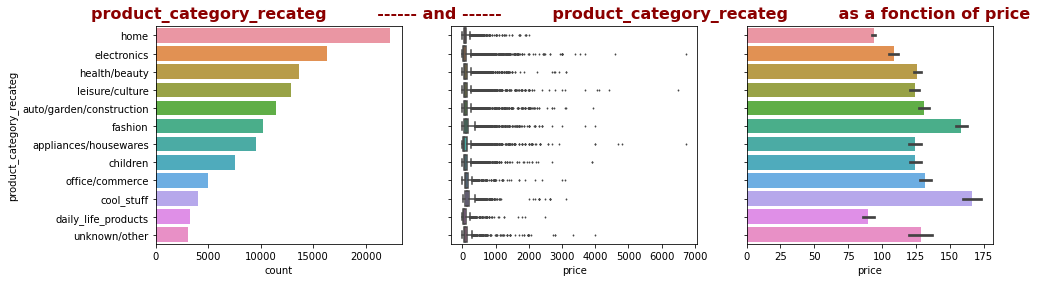

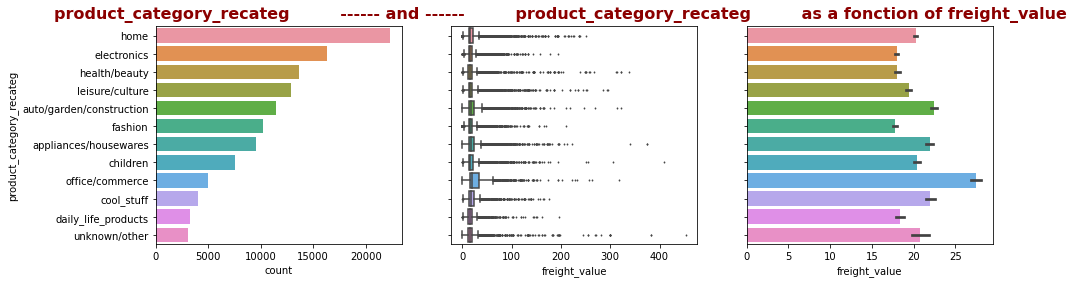

In [90]:
# verif avant recatégorisation
print('nb NaN product_category AVANT recatégorisation = ',
      merged_df[merged_df.product_category.isna() == True].shape[0])

# recategorisation de 'product_category'
merged_df['product_category_recateg'] = merged_df['product_category'].apply(recateg)

# verif après recatégorisation
print('-' * 100)
print('-' * 100)
print('nb NaN product_category APRES recatégorisation = ',
      merged_df[merged_df.product_category_recateg.isna() == True]\
      .shape[0])
print('-' * 50)
print(merged_df.product_category_recateg.value_counts())
print('-' * 50)
for f in ['price', 'freight_value']:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('product_category_recateg \
        ------ and ------ \
        product_category_recateg \
        as a fonction of {}'.format(f),
                 y=0.95, fontsize=16,
                 color='darkred', weight=800)
    plot_order = merged_df.product_category_recateg.value_counts().index
    g0 = sns.countplot(y='product_category_recateg',
                       data=merged_df, ax=axes[0],
                       order=plot_order)
    g1 = sns.boxplot(y='product_category_recateg', x=f,
                     data=merged_df, ax=axes[1], fliersize=1,
                     order=plot_order)
    g1.set_yticklabels([])
    g1.set_ylabel('')
    g2 = sns.barplot(y='product_category_recateg', x=f,
                     data=merged_df, ax=axes[2],
                     order=plot_order)
    g2.set_yticklabels([])
    g2.set_ylabel('')

### 2.4.2. Recatégorisation de customer_state

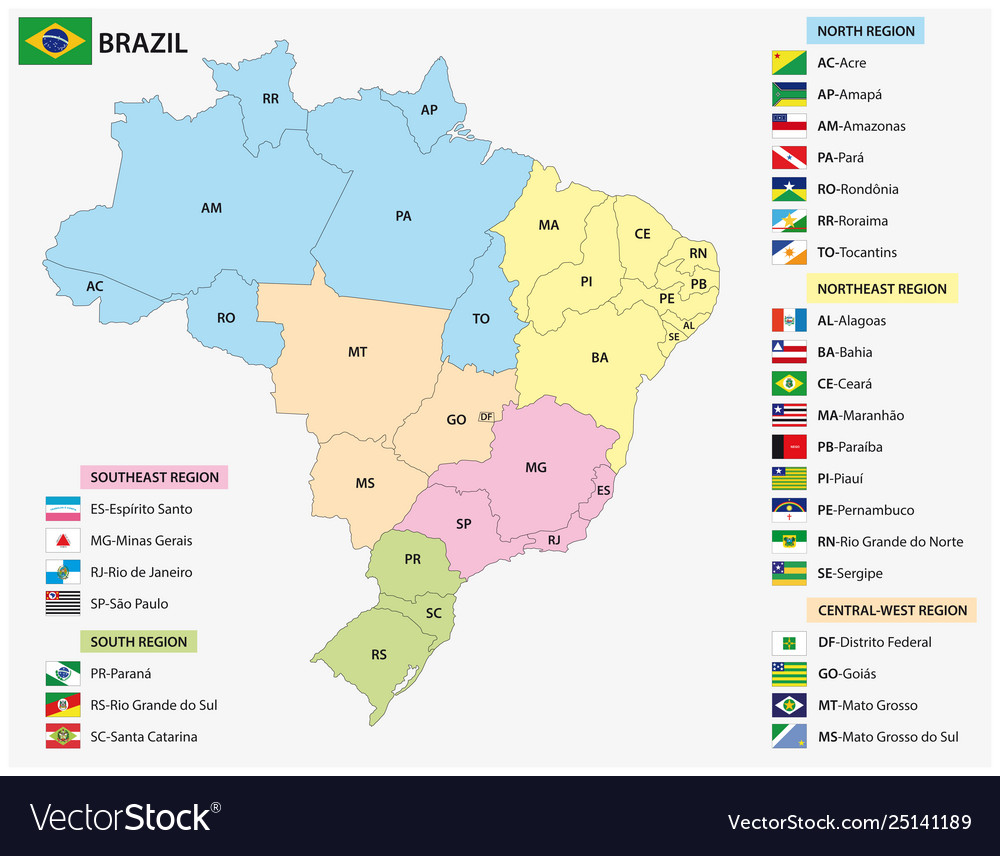

In [91]:
from IPython.display import Image
Image(filename='map-brazilian-states.jpg') 

In [92]:
# Nouvelles catégories
regions = {'SE': ['ES', 'MG', 'RJ', 'SP'],
           'S': ['PR', 'RS', 'SC'],
           'N': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
           'NE': ['AL', 'BA', 'CE', 'MA', 'PB', 'PI', 'PE', 'RN', 'SE'],
           'cW': ['DF', 'GO', 'MT', 'MS']}

In [93]:
def recateg_states_into_regions (feature):
    '''Fonction de recatégorisation de 'product_category' '''
    for key, value in regions.items():
        for val in value:
            if val in str(feature):
                return key
    return np.nan

In [94]:
# verif avant recatégorisation
print('nb NaN customer_state AVANT recatégorisation = ',
      merged_df[merged_df.customer_state.isna() == True]\
      .shape[0])
print('nb unique val customer_state AVANT recatégorisation = ',
      merged_df.customer_state.nunique())

# recategorisation de 'customer_state' dans une nouvelle colonne 'customer_region'
merged_df['customer_region'] = merged_df['customer_state']\
    .apply(recateg_states_into_regions)

# verif après recatégorisation
print('-' * 100)
print('-' * 100)
print('nb NaN customer_region APRES recatégorisation = ',
      merged_df[merged_df.customer_region.isna() == True]\
      .shape[0])
print('-' * 50)
print(merged_df.customer_region.value_counts())
print('-' * 50)

nb NaN customer_state AVANT recatégorisation =  0
nb unique val customer_state AVANT recatégorisation =  27
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
nb NaN customer_region APRES recatégorisation =  0
--------------------------------------------------
SE    81965
S     16962
NE    11082
cW     6976
N      2166
Name: customer_region, dtype: int64
--------------------------------------------------


## 2.5. export df cleané

In [95]:
merged_df.to_csv("merged_df_clean.csv")

# 3. Feature engineering
Création d'un nouveau df où index == customer_unique_id et avec nouvelles variables
- Récence
- Fréquence
- Montant dernière commande
- Montant panier moyen
- Montant sur une période donnée??
- prix moyen/max/min par article (frais de port inclus ??)
- Volume d'achat = mean de (max de 'order_item_id' par order_id = nb d'articles par commande) par customer_unique_id = volume d'achat
- temps moyen entre création panier et transaction (en rajoutant des "0" (??) pour 'order_approved_at' == NaN, i.e. commandes non finalisées A UTILISER POUR CLIENTS POTENTIELS (i.e. sont venus sur le site, étaient intéressés par des produits mais n'ont finalement pas acheté))
- délai de livraison estimé --> pour identifier clients pressés ?? pb des NaN
- consommateur local ou non
- use of voucher --> clients incités / incitable via voucher => ENCODAGE

+autres varaibles déjà existantes (groupées sur 'customer_unique_id' avec AGGFUNC adaptée)
- 'customer_unique_id'
- 'customer_zip_code_prefix' OU 'customer_city' OU 'customer_state' (devrait être toujours le même pour chaque customer_unique_id)
- 'payment_sequential' -- MEAN
- 'payment_type' -- MEAN après encodage?
- 'payment_installments' -- MEAN
- 'product_category_name' -- TOUTES?? cate la plus fréquente?? la plus dépensée?
- 'review_score' -- MEAN (= satisfaction moyenne client (à partager en 3 categ: satisfait, non satisfait, autre??))
- 'review_score' -- LAST (= satisfaction du client sur dernier achat)


+encodage features catégorielles???


## 3.1. Création du df 'data' et ajout des variables d'intérêt en vue du clustering

In [96]:
# Création du nouveau df
print('#### Création du nouveau dataframe \'data\'\
dont les index sont les \'customer_unique_id\'####')
data = pd.DataFrame()
    # Ajout customer_unique_id en tant qu'index
data['customer_unique_id'] = merged_df.customer_unique_id\
    .unique().tolist()
data = data.set_index('customer_unique_id')
    # verif
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('-' * 100)

def add_variable(existing_var, aggfunc, new_name_var):
    '''
    Fonction pour ajouter des variables au df data
    à partir de variables existantes du df merged_df (existing_var),
    après groupement sur "customer_unique_id",
    en utilisant la fonction d'aggrégation (aggfunc) adaptée,
    et en renommant la colonne (new_name_var)
    '''
    global data
    print('#### ajout de {} à partir de {} via la fonction d\'agrégation \"{}\"####'\
          .format(new_name_var, existing_var, aggfunc))
    # isolation/création variable à ajouter
    add_var = merged_df.groupby('customer_unique_id')[existing_var]\
        .agg(aggfunc).to_frame()
    # renommage de la variable ajoutée
    add_var.rename(columns={existing_var: new_name_var}, inplace=True)
    # Ajout au df data
    data = pd.merge(data, add_var, left_index=True, right_index=True, how='left')
    # Verif
    print('variable to add - df shape:', add_var.shape)
    print('data shape:', data.shape)
    print('data unique indices:', data.index.nunique())
    print('data columns:', data.columns.tolist())
    print('-' * 100)

# Ajout de 'customer_state', 'mean_payment_sequential', 'most_freq_payment_type', 
# 'mean_payment_installments', 'most_freq_product_categ', 'nb_product_categ', 'mean_review_score'
    # définition des combinaisons (existing_var, aggfunc, new_name_var) correspondantes:
existing_var_to_add = [['customer_region', pd.Series.mode, 'customer_region'],
                       ['payment_sequential', pd.Series.mean, 'mean_payment_sequential'],
                       ['payment_type', pd.Series.mode, 'most_freq_payment_type'],
                       ['payment_installments', pd.Series.mean, 'mean_payment_installments'],
                       ['product_category_recateg', pd.Series.mode, 'most_freq_product_categ'],
                       ['product_category_recateg', pd.Series.nunique, 'nb_product_categ'],
                       ['review_score', pd.Series.mean, 'mean_review_score']]
    # Ajout des variables en question
for existing_var, aggfunc, new_name_var in existing_var_to_add:
    add_variable(existing_var, aggfunc, new_name_var)
    
# Ajout de last_review_score
print('#### ajout de {} à partir de {} ####'.format('last_review_score', 'review_score'))
    # isolation/création variable à ajouter
add_var = merged_df.sort_values('review_creation_date')\
    .groupby('customer_unique_id')['review_score'].last().to_frame()
    # renommage de la variable ajoutée
add_var.rename(columns={'review_score': 'last_review_score'}, inplace=True)
    # Ajout au df data
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
    # Verif
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)

# Ajout Récence et Ancienneté
    # Définition de la date la plus récente
most_recent_date = max(max(merged_df.order_purchase_timestamp),
                       max(merged_df.order_approved_at),
                       max(merged_df.order_delivered_carrier_date),
                       max(merged_df.order_delivered_customer_date))
print('most_recent_date:', most_recent_date)
    # Ajout Récence (Recency(days))
add_variable('order_purchase_timestamp',
             lambda x: (most_recent_date - x.max()) / np.timedelta64(1, "D"),
             'Recency(days)')
    # Ajout Ancienneté (Seniority(days))
add_variable('order_purchase_timestamp',
             lambda x: (most_recent_date - x.min()) / np.timedelta64(1, "D"),
             'Seniority(days)')

# Ajout nb total de commandes passées par le client sur l'ensemble de la période (nb_orders)
add_variable('order_id', pd.Series.nunique, 'nb_orders')

# Ajout de Fréquence d'achat (Frequency(days))
print('#### ajout de {} à partir de {} ####'\
      .format('Frequency(days)', 'Recency, Seniority et nb_orders'))
data['Frequency(days)'] = (data['Seniority(days)'] - data['Recency(days)']) / data.nb_orders
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)

# Ajout montant dernière commande (last_order_amount)
print('#### ajout de last_order_amount à partir de order_id,\
 order_purchase_timestamp et payment_value ####')
add_var = merged_df[merged_df.order_item_id < 1.5]\
    .groupby(['customer_unique_id','order_id', 'order_purchase_timestamp'])\
    ['payment_value'].sum().to_frame().\
    sort_values('order_purchase_timestamp').\
    groupby('customer_unique_id')['payment_value'].last().to_frame()
add_var.rename(columns={'payment_value': 'last_order_amount'}, inplace=True)
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)

# Ajout montant panier moyen (mean_order_amount)
print('#### ajout de mean_order_amount à partir de order_id et payment_value ####')
add_var = merged_df[merged_df.order_item_id < 1.5]\
    .groupby(['customer_unique_id','order_id'])['payment_value']\
    .sum().to_frame().\
    groupby('customer_unique_id')['payment_value'].mean().to_frame()
add_var.rename(columns={'payment_value': 'mean_order_amount'},
               inplace=True)
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)

# Ajout montant max (max_order_amount)
print('#### ajout de max_order_amount à partir de order_id et payment_value ####')
add_var = merged_df[merged_df.order_item_id < 1.5]\
    .groupby(['customer_unique_id','order_id'])['payment_value']\
    .sum().to_frame().\
    groupby('customer_unique_id')['payment_value'].max().to_frame()
add_var.rename(columns={'payment_value': 'max_order_amount'}, inplace=True)
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)

# Ajout de min, max, mean item price
    # Création variable prix par article, i.e. 'price+freight_value'
merged_df['price+freight_value'] = merged_df.price + merged_df.freight_value
    # Ajout de min_item_price
print('#### ajout de min_item_price à partir de order_id, order_item_id et price+freight_value ####')
add_var = merged_df.groupby(['customer_unique_id',
                             'order_id',
                             'order_item_id'])\
    ['price+freight_value'].mean().to_frame().\
    groupby('customer_unique_id')['price+freight_value']\
    .min().to_frame()
add_var.rename(columns={'price+freight_value': 'min_item_price'},
               inplace=True)
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)
    # Ajout de max_item_price
print('#### ajout de max_item_price à partir de order_id, order_item_id et price+freight_value ####')
add_var = merged_df.groupby(['customer_unique_id',
                             'order_id',
                             'order_item_id'])\
    ['price+freight_value'].mean().to_frame().\
    groupby('customer_unique_id')['price+freight_value']\
    .max().to_frame()
add_var.rename(columns={'price+freight_value': 'max_item_price'}, inplace=True)
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)
    # Ajout de mean_item_price
print('#### ajout de mean_item_price à partir de order_id, order_item_id et price+freight_value ####')
add_var = merged_df.groupby(['customer_unique_id',
                             'order_id','order_item_id'])\
    ['price+freight_value'].mean().to_frame().\
    groupby('customer_unique_id')['price+freight_value']\
    .mean().to_frame()
add_var.rename(columns={'price+freight_value': 'mean_item_price'},
               inplace=True)
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)

# Ajout volume d'achat moyen (mean_nb_items)
print('#### ajout de mean_nb_items à partir de order_id et order_item_id ####')
add_var = merged_df.groupby(['customer_unique_id','order_id'])\
    ['order_item_id'].max().to_frame().\
    groupby('customer_unique_id')['order_item_id'].mean().to_frame()
add_var.rename(columns={'order_item_id': 'mean_nb_items'},
               inplace=True)
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)

# Ajout de temps moyen et min entre création panier et transaction (mean_ and min_ approvement-purchase_timedelta)
    # Création de approvement-purchase_timedelta dans merged_df
merged_df['approvement-purchase_timedelta(min)'] =\
    (merged_df.order_approved_at - merged_df.order_purchase_timestamp)\
    / np.timedelta64(1, "m")
    # Ajout de mean_approvement-purchase_timedelta dans data
print('#### ajout de mean_approvement-purchase_timedelta(mins)\
 à partir de order_id et approvement-purchase_timedelta(min) ####')
add_var = merged_df.groupby(['customer_unique_id','order_id'])\
    ['approvement-purchase_timedelta(min)'].mean().to_frame().\
    groupby('customer_unique_id')['approvement-purchase_timedelta(min)']\
    .mean().to_frame()
add_var.rename(columns={'approvement-purchase_timedelta(min)':\
                        'mean_approvement-purchase_timedelta(mins)'},
               inplace=True)
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)
    # Ajout de min_approvement-purchase_timedelta dans data
add_variable('approvement-purchase_timedelta(min)', min, 'min_approvement-purchase_timedelta(mins)')

# Ajout de délai moyen de livraison estimé (mean_estimated_delivery_timelapse(days))
    # Ajout estimated_delivery_timelapse(days) dans merged_df
merged_df['estimated_delivery_timelapse(days)'] =\
    (merged_df.order_estimated_delivery_date - merged_df.order_purchase_timestamp)\
    / np.timedelta64(1, "D")
    # Ajout mean_estimated_delivery_timelapse(days) à data
print('#### ajout de mean_estimated_delivery_timelapse(days)\
 à partir de order_id et estimated_delivery_timelapse(days) ####')
add_var = merged_df.groupby(['customer_unique_id','order_id'])\
    ['estimated_delivery_timelapse(days)'].mean().to_frame().\
    groupby('customer_unique_id')['estimated_delivery_timelapse(days)']\
    .mean().to_frame()
add_var.rename(columns={'estimated_delivery_timelapse(days)':\
                        'mean_estimated_delivery_timelapse(days)'},
               inplace=True)
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)

# consommateur local ou non
    # Ajout Local_consumer à merged df
merged_df['Local_consumer'] = np\
    .where(merged_df.customer_state == merged_df.seller_state, 1, 0)
    # Ajout Local_consumer_grade à data
print('#### ajout de Local_consumer_grade à partir\
 de order_id, order_item_id et Local_consumer ####')
add_var = merged_df.groupby(['customer_unique_id',
                             'order_id',
                             'order_item_id'])\
    ['Local_consumer'].mean().to_frame().\
    groupby('customer_unique_id')['Local_consumer']\
    .mean().to_frame()
add_var.rename(columns={'Local_consumer': 'Local_consumer_grade'},
               inplace=True)
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)

# use of voucher --> clients incités / incitable via voucher => ENCODAGE
    # Ajout de 'use_of_voucher' à merged_df
merged_df['use_of_voucher'] = np.where(merged_df.payment_type == 'voucher', 1, 0)
    # Ajout de use_of_voucher (== fraction of orders paid with at least 1 voucher) à data
print('#### ajout de use_of_voucher à partir de order_id et use_of_voucher ####')
add_var = merged_df.groupby(['customer_unique_id','order_id'])\
    ['use_of_voucher'].max().to_frame().\
    groupby('customer_unique_id')['use_of_voucher'].mean().to_frame()
data = pd.merge(data, add_var, left_index=True, right_index=True, how='left') 
print('variable to add - df shape:', add_var.shape)
print('data shape:', data.shape)
print('data unique indices:', data.index.nunique())
print('data columns:', data.columns.tolist())
print('-' * 100)
    
print('DONE!!')

#### Création du nouveau dataframe 'data'dont les index sont les 'customer_unique_id'####
data shape: (96096, 0)
data unique indices: 96096
----------------------------------------------------------------------------------------------------
#### ajout de customer_region à partir de customer_region via la fonction d'agrégation "<function Series.mode at 0x000001F34DC17EE0>"####
variable to add - df shape: (96096, 1)
data shape: (96096, 1)
data unique indices: 96096
data columns: ['customer_region']
----------------------------------------------------------------------------------------------------
#### ajout de mean_payment_sequential à partir de payment_sequential via la fonction d'agrégation "<function Series.mean at 0x000001F34DC1E700>"####
variable to add - df shape: (96096, 1)
data shape: (96096, 2)
data unique indices: 96096
data columns: ['customer_region', 'mean_payment_sequential']
--------------------------------------------------------------------------------------------------

variable to add - df shape: (96096, 1)
data shape: (96096, 17)
data unique indices: 96096
data columns: ['customer_region', 'mean_payment_sequential', 'most_freq_payment_type', 'mean_payment_installments', 'most_freq_product_categ', 'nb_product_categ', 'mean_review_score', 'last_review_score', 'Recency(days)', 'Seniority(days)', 'nb_orders', 'Frequency(days)', 'last_order_amount', 'mean_order_amount', 'max_order_amount', 'min_item_price', 'max_item_price']
----------------------------------------------------------------------------------------------------
#### ajout de mean_item_price à partir de order_id, order_item_id et price+freight_value ####
variable to add - df shape: (96096, 1)
data shape: (96096, 18)
data unique indices: 96096
data columns: ['customer_region', 'mean_payment_sequential', 'most_freq_payment_type', 'mean_payment_installments', 'most_freq_product_categ', 'nb_product_categ', 'mean_review_score', 'last_review_score', 'Recency(days)', 'Seniority(days)', 'nb_orders', 

In [97]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 7c396fd4830fd04220f754e42b4e5bff to 60350aa974b26ff12caad89e55993bd6
Data columns (total 24 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   customer_region                            96096 non-null  object 
 1   mean_payment_sequential                    96096 non-null  float64
 2   most_freq_payment_type                     96096 non-null  object 
 3   mean_payment_installments                  96096 non-null  float64
 4   most_freq_product_categ                    96096 non-null  object 
 5   nb_product_categ                           96096 non-null  int64  
 6   mean_review_score                          96096 non-null  float64
 7   last_review_score                          96096 non-null  int64  
 8   Recency(days)                              96096 non-null  float64
 9   Seniority(days)                          

In [29]:
# Verif cohérence des variables calculées 
# et premier aperçu de leur distribution
data.describe(include='all')

In [99]:
# Visualisation df
data

,customer_region,mean_payment_sequential,most_freq_payment_type,mean_payment_installments,most_freq_product_categ,nb_product_categ,mean_review_score,last_review_score,Recency(days),Seniority(days),nb_orders,Frequency(days),last_order_amount,mean_order_amount,max_order_amount,min_item_price,max_item_price,mean_item_price,mean_nb_items,mean_approvement-purchase_timedelta(mins),min_approvement-purchase_timedelta(mins),mean_estimated_delivery_timelapse(days),Local_consumer_grade,use_of_voucher
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,
7c396fd4830fd04220f754e42b4e5bff,SE,1.75,"[credit_card, voucher]",1.0,appliances/housewares,2,4.25,4,380.707569,408.686678,2,13.989554,38.71,41.41,44.11,38.71,44.11,41.41,1.0,13.741667,10.700000,13.033617,1.0,0.5
af07308b275d755c9edb36a90c618231,NE,1.00,boleto,1.0,health/beauty,1,4.00,4,85.301273,85.301273,1,0.000000,141.46,141.46,141.46,141.46,141.46,141.46,1.0,1842.833333,1842.833333,19.137766,0.0,0.0
3a653a41f6f9fc3d2a113cf8398680e8,cW,1.00,credit_card,3.0,auto/garden/construction,1,5.00,5,70.803218,70.803218,1,0.000000,179.12,179.12,179.12,179.12,179.12,179.12,1.0,16.566667,16.566667,26.639711,0.0,0.0
7c142cf63193a1473d2e66489a9ae977,NE,1.00,credit_card,1.0,daily_life_products,1,5.00,5,333.352326,333.352326,1,0.000000,72.20,72.20,72.20,72.20,72.20,72.20,1.0,17.883333,17.883333,26.188819,0.0,0.0
72632f0f9dd73dfee390c9b22eb56dd6,SE,1.00,credit_card,1.0,office/commerce,1,5.00,5,246.275556,246.275556,1,0.000000,28.62,28.62,28.62,28.62,28.62,28.62,1.0,61.833333,61.833333,12.112049,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6359f309b166b0196dbf7ad2ac62bb5a,SE,1.00,credit_card,3.0,health/beauty,1,5.00,5,587.750949,587.750949,1,0.000000,85.08,85.08,85.08,85.08,85.08,85.08,1.0,0.000000,0.000000,18.587442,1.0,0.0
da62f9e57a76d978d02ab5362c509660,SE,1.00,credit_card,3.0,children,1,4.00,4,253.622558,253.622558,1,0.000000,195.00,195.00,195.00,195.00,195.00,195.00,1.0,11.650000,11.650000,23.459051,1.0,0.0
737520a9aad80b3fbbdad19b66b37b30,NE,1.00,credit_card,5.0,appliances/housewares,1,5.00,5,416.547731,416.547731,1,0.000000,271.01,271.01,271.01,271.01,271.01,271.01,1.0,17.550000,17.550000,30.384225,0.0,0.0


**/!\ ==> customer_region, most_freq_payment_type et most_freq_product_categ ont visiblement des valeurs de type liste (et non de type simple string)**

In [30]:
# Verif coherence des xxx_order_amount == 13664.08
    # identification du customer_unique_id associé
data[data.mean_order_amount == 13664.08]

In [31]:
    # Visualisation du customer_unique_id en question
merged_df[merged_df.customer_unique_id == '0a0a92112bd4c708ca5fde585afaa872']

==> Tout semble ok!

## 3.2. encodage des variables catégorielles
- customer_region
- most_freq_payment_type
- most_freq_product_categ

Rappel: /!\ présence de valeurs de type liste (et non de type simple string) dans ces colonnes

In [102]:
def encode_categ_features (feature_merged_df, feature_data):
    '''
    Fonction pour encoder une variable catégorielle du df data (feature_data)
    en n colonnes booléennes, où n= nb de catégories initiales = nb de catégories
    uniques dans la feature correspondante de merged_df (feature_merged_df)
    '''
    for category in merged_df[feature_merged_df].unique().tolist():
        def encoding_function (reported_categ):
            '''
            Fonction retournant 1 si la catégorie / liste de catégorie(s)
            répertoriée dans la variable catégorielle à encoder du df data
            contient la catégorie unique associée à la colonne booléenne
            en cours d'encodage, et retournant 0 sinon
            '''
            if str(category) in str(reported_categ):
                return 1
            else:
                return 0
        data['{}_{}'.format(feature_data, category)] = data[feature_data].apply(encoding_function)

for feature_merged_df, feature_data\
    in [['customer_region', 'customer_region'],
        ['product_category_recateg', 'most_freq_product_categ'],
        ['payment_type', 'most_freq_payment_type']]:
    encode_categ_features(feature_merged_df, feature_data)

In [103]:
# Vérification
pd.set_option('display.max_columns', data.shape[1])
data

,customer_region,mean_payment_sequential,most_freq_payment_type,mean_payment_installments,most_freq_product_categ,nb_product_categ,mean_review_score,last_review_score,Recency(days),Seniority(days),nb_orders,Frequency(days),last_order_amount,mean_order_amount,max_order_amount,min_item_price,max_item_price,mean_item_price,mean_nb_items,mean_approvement-purchase_timedelta(mins),min_approvement-purchase_timedelta(mins),mean_estimated_delivery_timelapse(days),Local_consumer_grade,use_of_voucher,customer_region_SE,customer_region_NE,customer_region_cW,customer_region_S,customer_region_N,most_freq_product_categ_appliances/housewares,most_freq_product_categ_health/beauty,most_freq_product_categ_auto/garden/construction,most_freq_product_categ_daily_life_products,most_freq_product_categ_office/commerce,most_freq_product_categ_unknown/other,most_freq_product_categ_home,most_freq_product_categ_electronics,most_freq_product_categ_children,most_freq_product_categ_cool_stuff,most_freq_product_categ_fashion,most_freq_product_categ_leisure/culture,most_freq_payment_type_credit_card,most_freq_payment_type_voucher,most_freq_payment_type_boleto,most_freq_payment_type_debit_card,most_freq_payment_type_refund
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7c396fd4830fd04220f754e42b4e5bff,SE,1.75,"[credit_card, voucher]",1.0,appliances/housewares,2,4.25,4,380.707569,408.686678,2,13.989554,38.71,41.41,44.11,38.71,44.11,41.41,1.0,13.741667,10.700000,13.033617,1.0,0.5,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
af07308b275d755c9edb36a90c618231,NE,1.00,boleto,1.0,health/beauty,1,4.00,4,85.301273,85.301273,1,0.000000,141.46,141.46,141.46,141.46,141.46,141.46,1.0,1842.833333,1842.833333,19.137766,0.0,0.0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3a653a41f6f9fc3d2a113cf8398680e8,cW,1.00,credit_card,3.0,auto/garden/construction,1,5.00,5,70.803218,70.803218,1,0.000000,179.12,179.12,179.12,179.12,179.12,179.12,1.0,16.566667,16.566667,26.639711,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7c142cf63193a1473d2e66489a9ae977,NE,1.00,credit_card,1.0,daily_life_products,1,5.00,5,333.352326,333.352326,1,0.000000,72.20,72.20,72.20,72.20,72.20,72.20,1.0,17.883333,17.883333,26.188819,0.0,0.0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
72632f0f9dd73dfee390c9b22eb56dd6,SE,1.00,credit_card,1.0,office/commerce,1,5.00,5,246.275556,246.275556,1,0.000000,28.62,28.62,28.62,28.62,28.62,28.62,1.0,61.833333,61.833333,12.112049,1.0,0.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6359f309b166b0196dbf7ad2ac62bb5a,SE,1.00,credit_card,3.0,health/beauty,1,5.00,5,587.750949,587.750949,1,0.000000,85.08,85.08,85.08,85.08,85.08,85.08,1.0,0.000000,0.000000,18.587442,1.0,0.0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
da62f9e57a76d978d02ab5362c509660,SE,1.00,credit_card,3.0,children,1,4.00,4,253.622558,253.622558,1,0.000000,195.00,195.00,195.00,195.00,195.00,195.00,1.0,11.650000,11.650000,23.459051,1.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
737520a9aad80b3fbbdad19b66b37b30,NE,1.00,credit_card,5.0,appliances/housewares,1,5.00,5,416.547731,416.547731,1,0.000000,271.01,271.01,271.01,271.01,271.01,271.01,1.0,17.550000,17.550000,30.384225,0.0,0.0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## 3.3. export df pour clustering

In [104]:
# suppression des variables catégorielles 
# et variables inutiles ('most_freq_payment_type_refund', seulement 3 valeurs)
data_for_clustering =\
    data.drop(columns=['customer_region',
                       'most_freq_payment_type',
                       'most_freq_product_categ',
                       'most_freq_payment_type_refund'])

# export df
data_for_clustering.to_csv("data_for_clustering.csv")

# 4. Analyse exploratoire
## 4.1. Analyse univariée 1

In [105]:
bool_features = ['customer_region_SE',
                 'customer_region_NE',
                 'customer_region_cW',
                 'customer_region_S',
                 'customer_region_N',
                 'most_freq_product_categ_appliances/housewares',
                 'most_freq_product_categ_health/beauty',
                 'most_freq_product_categ_auto/garden/construction',
                 'most_freq_product_categ_daily_life_products',
                 'most_freq_product_categ_office/commerce',
                 'most_freq_product_categ_unknown/other',
                 'most_freq_product_categ_home',
                 'most_freq_product_categ_electronics',
                 'most_freq_product_categ_children',
                 'most_freq_product_categ_cool_stuff',
                 'most_freq_product_categ_fashion',
                 'most_freq_product_categ_leisure/culture',
                 'most_freq_payment_type_credit_card',
                 'most_freq_payment_type_voucher',
                 'most_freq_payment_type_boleto',
                 'most_freq_payment_type_debit_card']

num_d_features = ['nb_product_categ',
                  'last_review_score',
                  'nb_orders']

num_c_features = ['mean_payment_sequential',
                  'mean_payment_installments',
                  'mean_review_score',
                  'Recency(days)',
                  'Seniority(days)',
                  'Frequency(days)',
                  'last_order_amount',
                  'mean_order_amount',
                  'max_order_amount',
                  'min_item_price',
                  'max_item_price',
                  'mean_item_price',
                  'mean_nb_items',
                  'mean_approvement-purchase_timedelta(mins)',
                  'min_approvement-purchase_timedelta(mins)',
                  'mean_estimated_delivery_timelapse(days)',
                  'Local_consumer_grade',
                  'use_of_voucher']

<ipython-input-106-58a9eec100c5>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2, figsize=(15, 4))
<ipython-input-106-58a9eec100c5>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))
<ipython-input-106-58a9eec100c5>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt

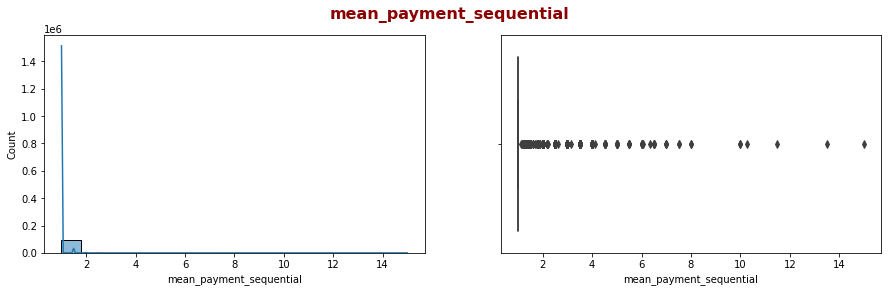

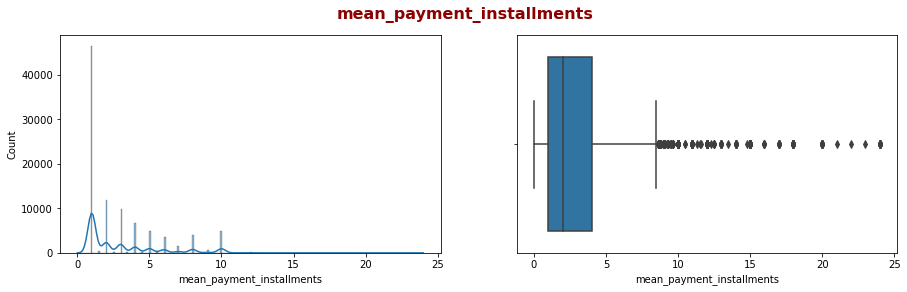

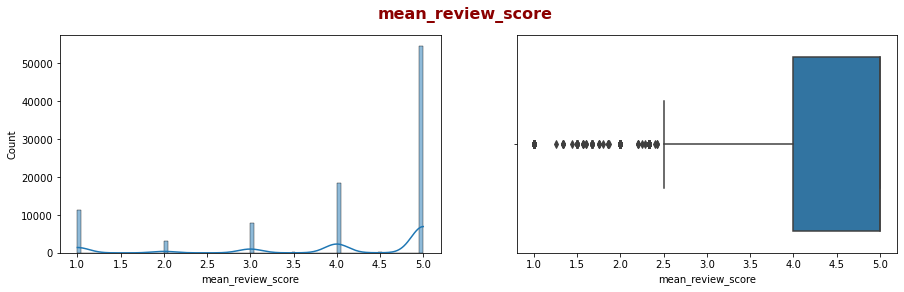

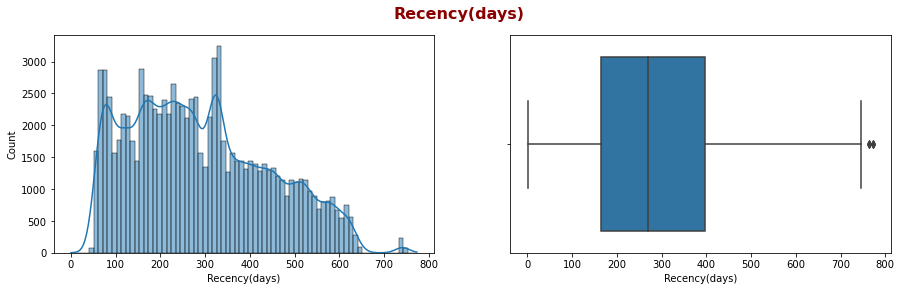

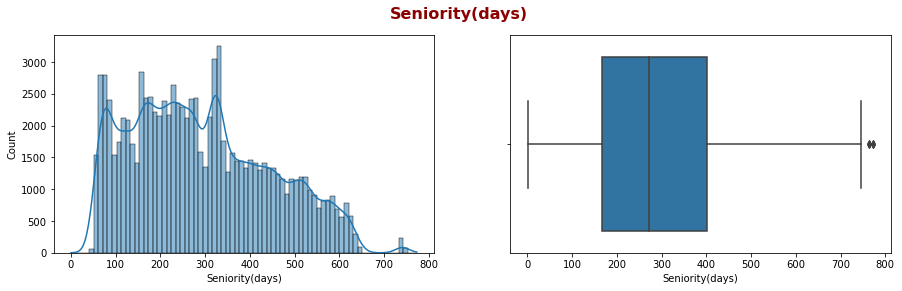

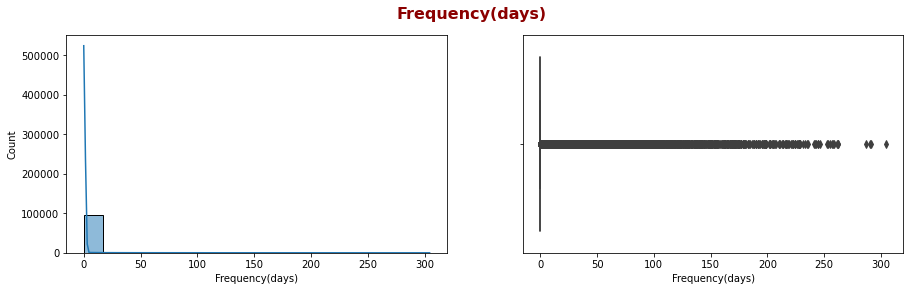

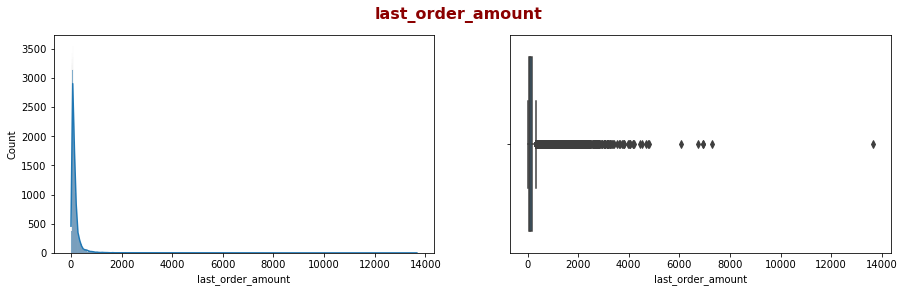

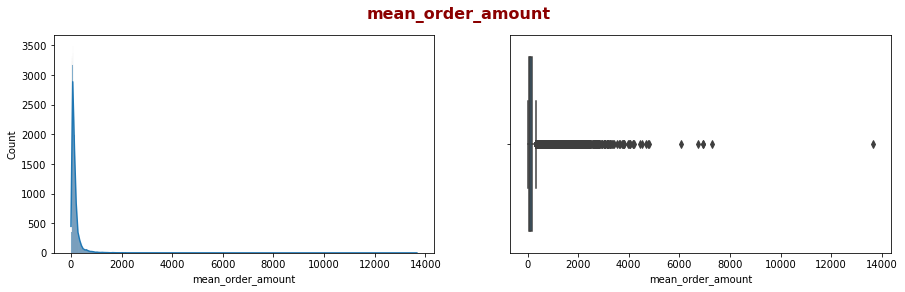

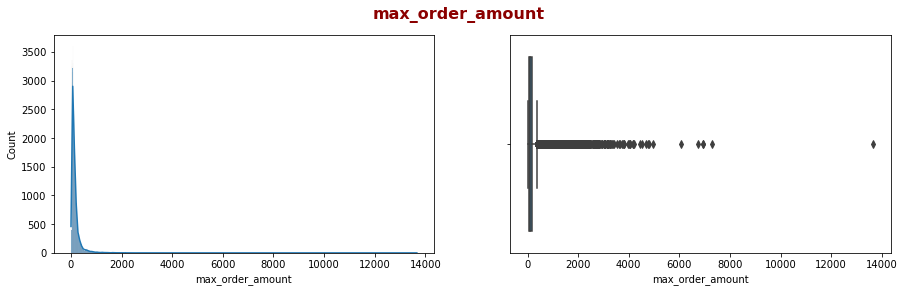

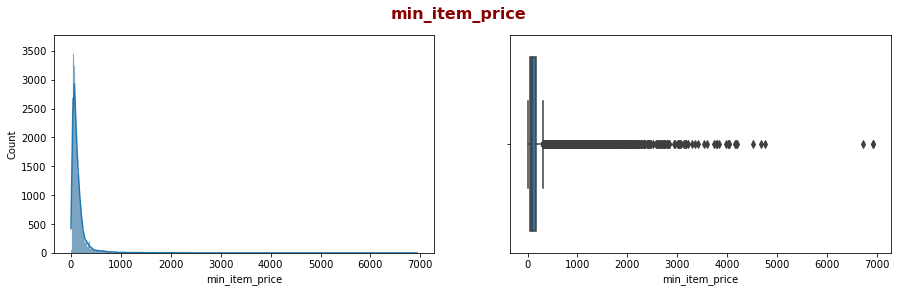

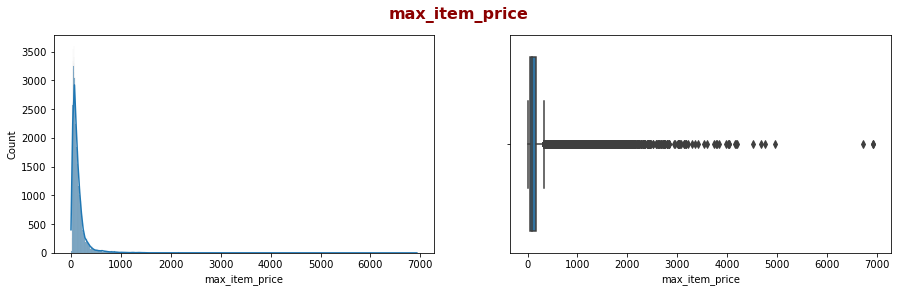

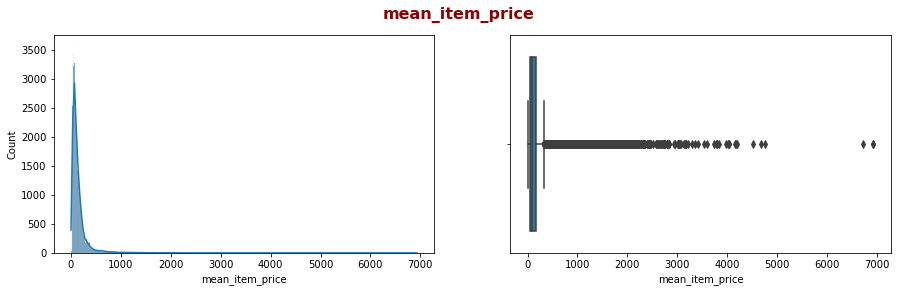

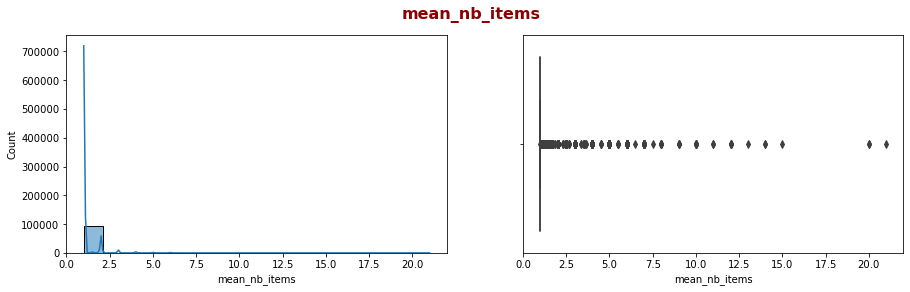

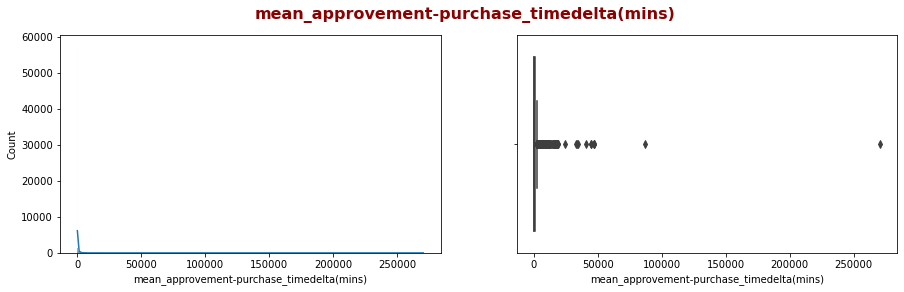

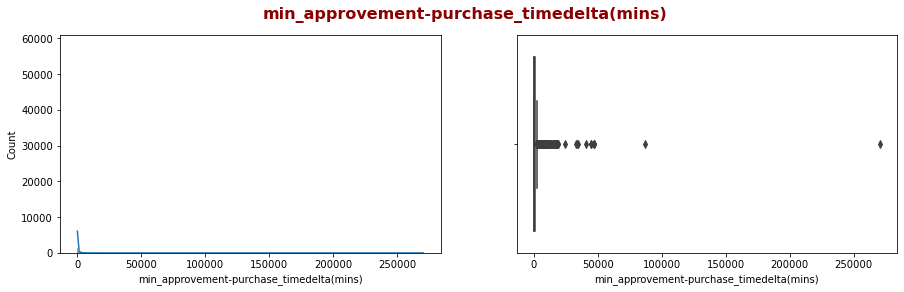

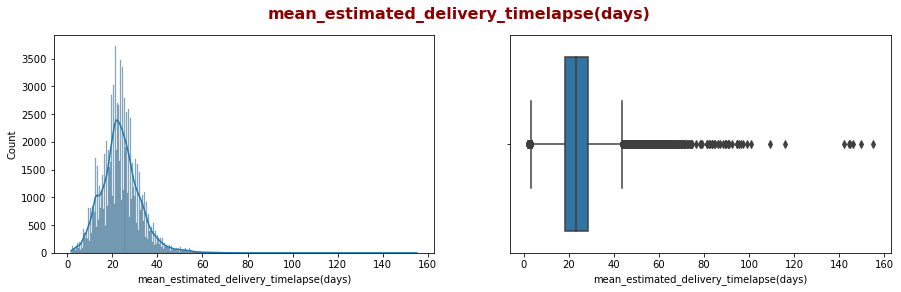

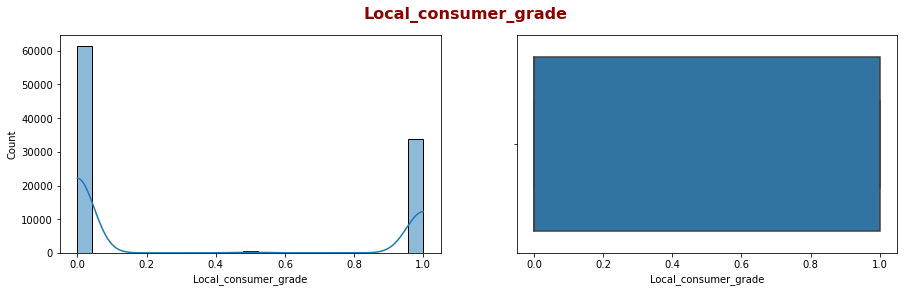

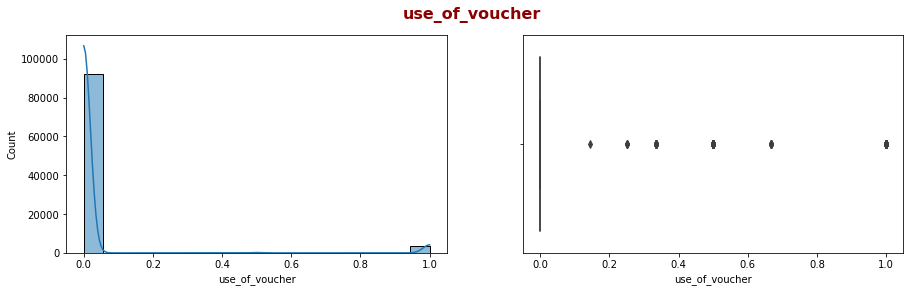

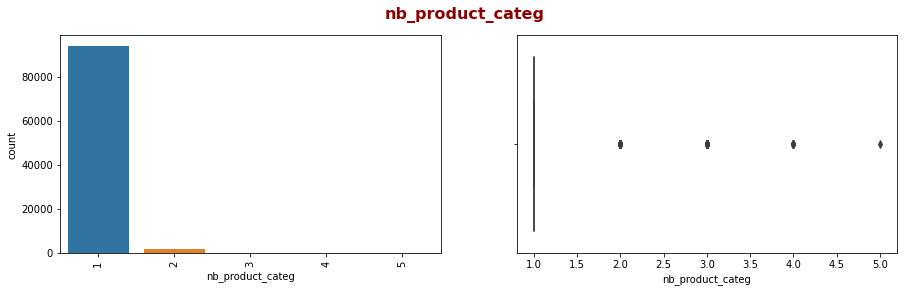

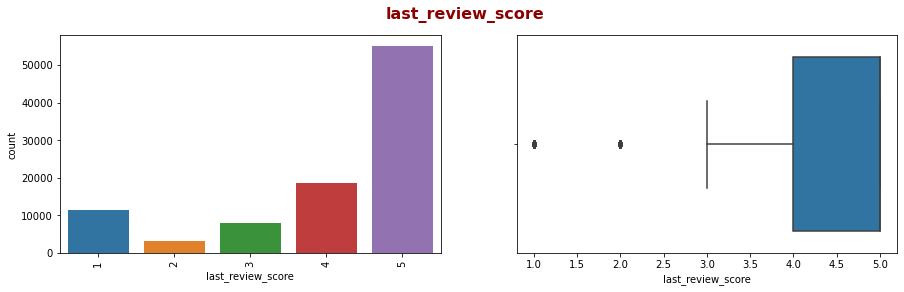

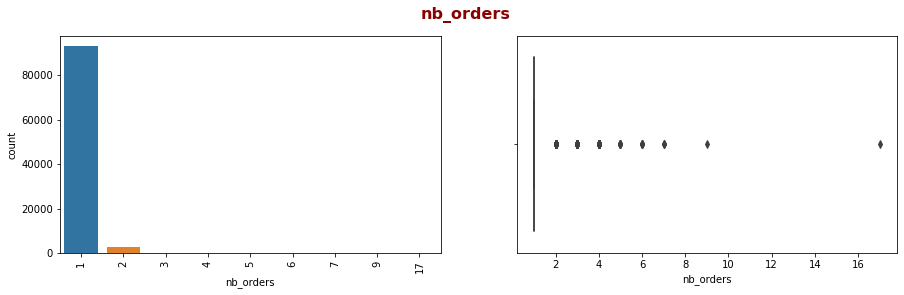

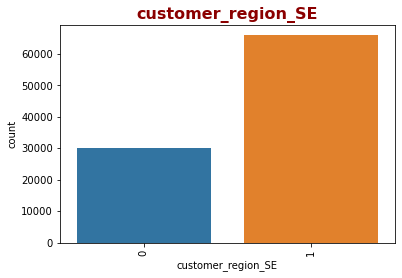

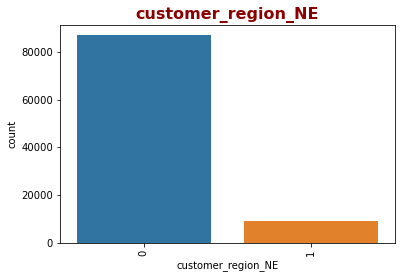

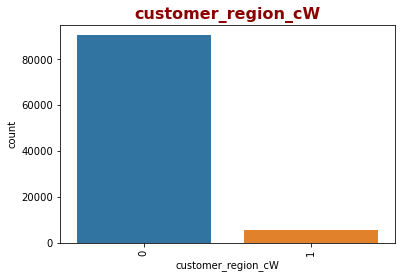

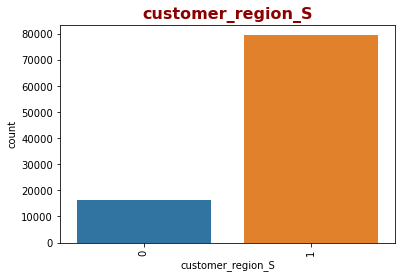

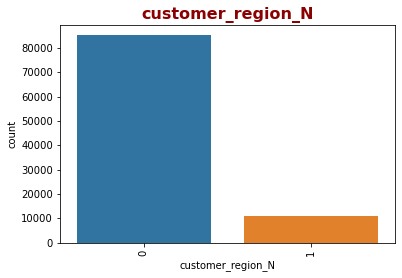

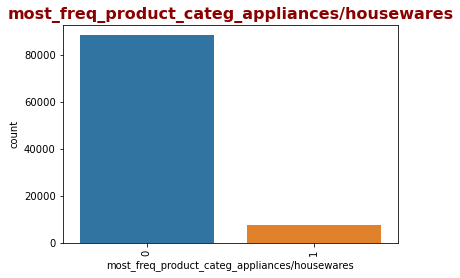

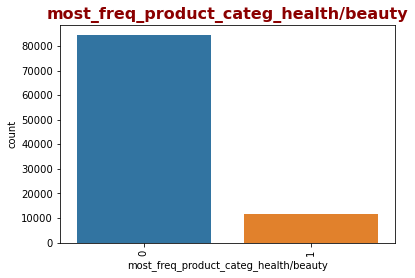

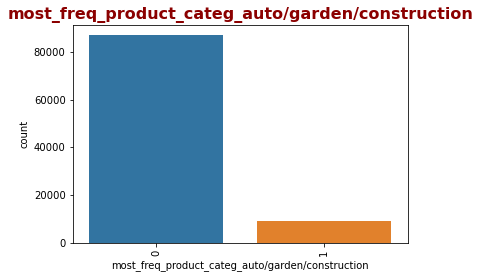

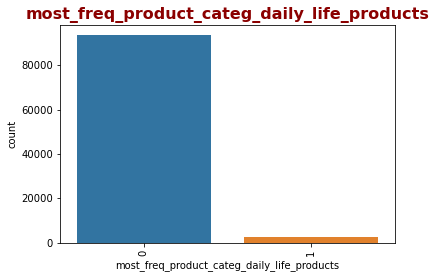

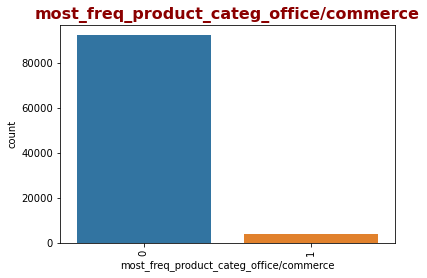

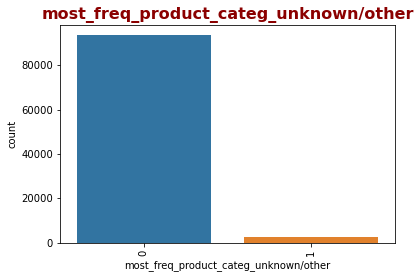

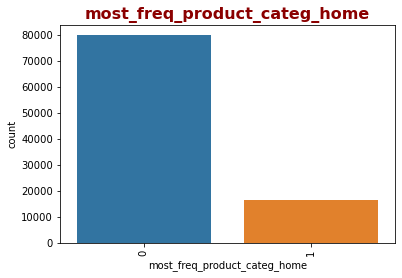

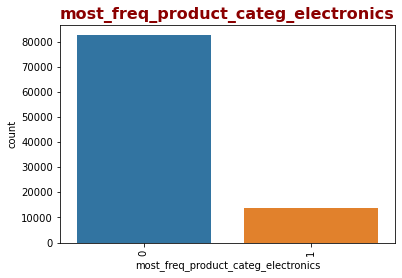

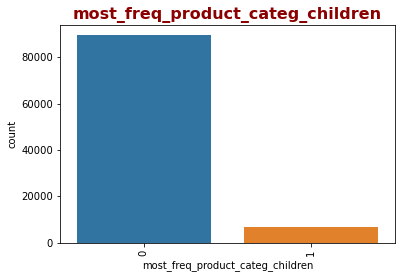

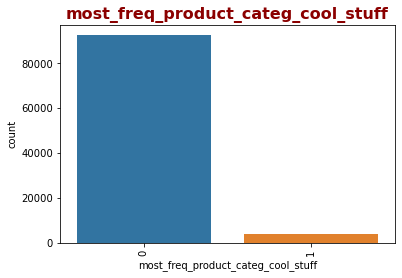

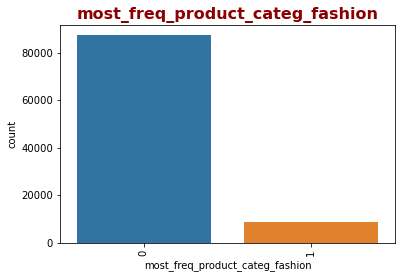

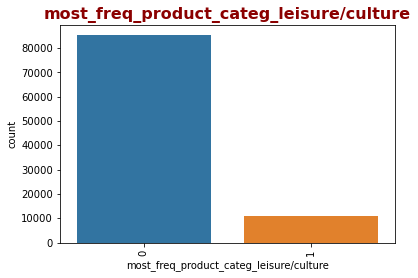

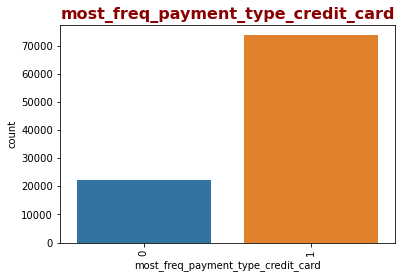

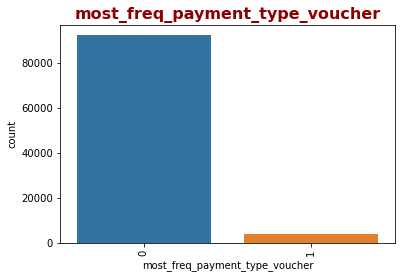

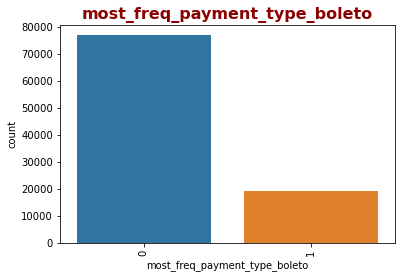

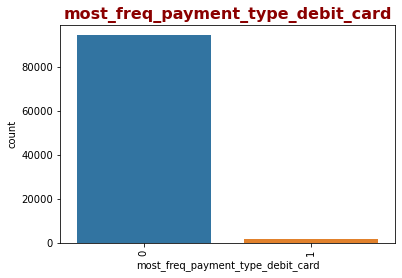

In [106]:
# Visualisation de la distribution des variables
for f in num_c_features:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f, fontsize=16, color='darkred', weight=800)
    g1 = sns.histplot(x=f, data=data_for_clustering, kde=True, ax=axes[0])
    g2 = sns.boxplot(x=f, data=data_for_clustering, ax=axes[1])

for f in num_d_features:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f, fontsize=16, color='darkred', weight=800)
    g1 = sns.countplot(x=f, data=data_for_clustering, ax=axes[0])
    g1.tick_params(axis='x', rotation=90)
    g2 = sns.boxplot(x=f, data=data_for_clustering, ax=axes[1])
    
for f in bool_features:
    plt.figure(figsize=(6,4))
    plt.title(f, fontsize=16, color='darkred', weight=800)
    g = sns.countplot(x=f, data=data_for_clustering)
    g.tick_params(axis='x', rotation=90)

**Bilan**:
- Frequency: pas très informative car la plupart des customer_unique_id ont fait une seule commande et leur Frequency associée == 0
- transfo log: last_order_amount, mean_order_amount, max_order_amount, min_item_price, max_item_price, mean_item_price, 
- transfo log ???: mean_approvement-purchase_timedelta(mins), min_approvement-purchase_timedelta(mins),
- outlier to delete: mean_estimated_delivery_timelapse(days) < 0   ---- ou alors: remplacer order_approved_at par order_purchase_timestamp dans calcul de mean_estimated_delivery_timelapse(days) == OPTION RETENUE, PROBLEME RESOLU

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-p

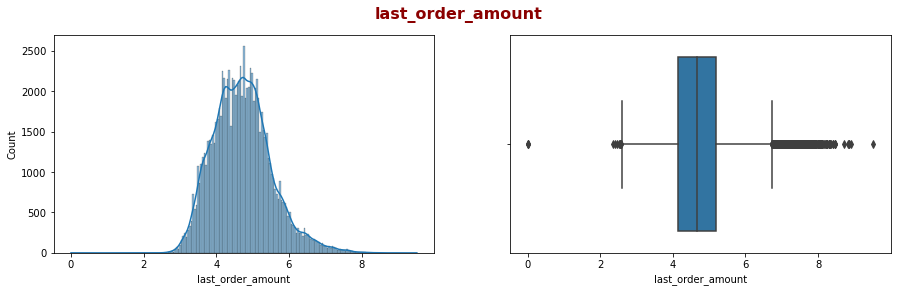

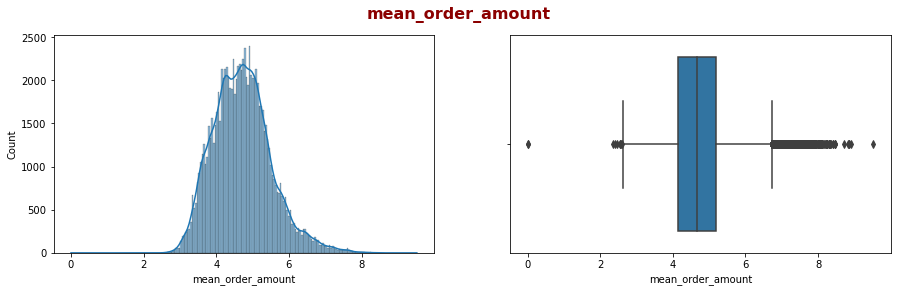

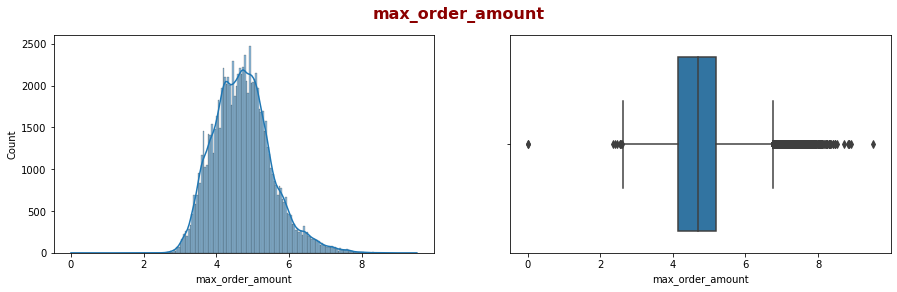

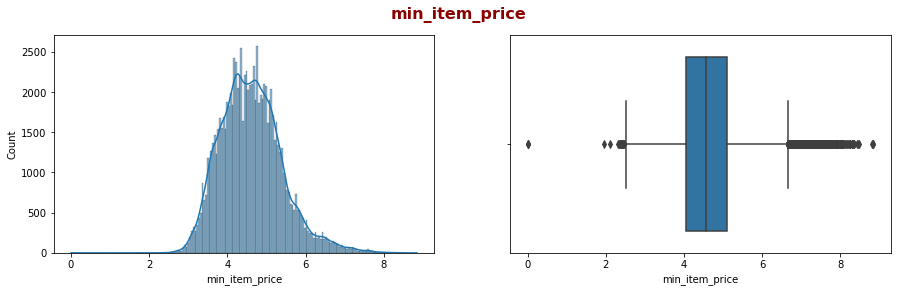

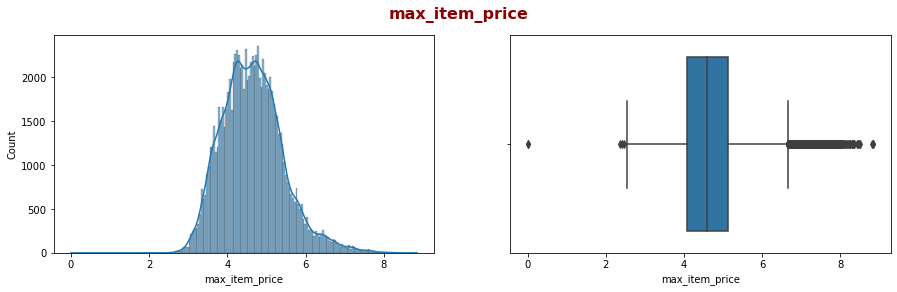

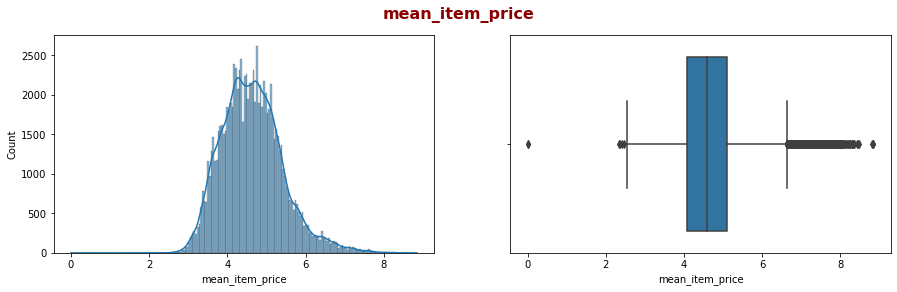

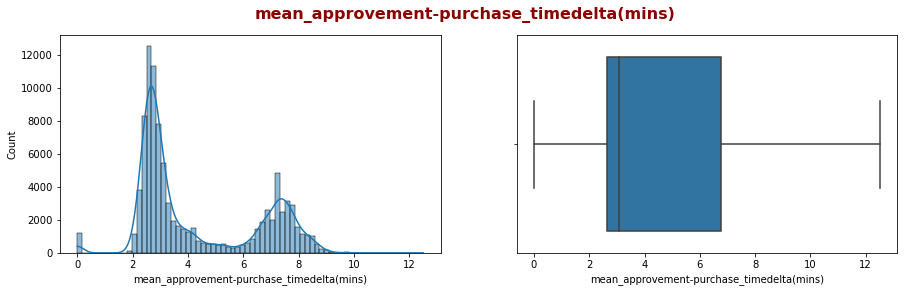

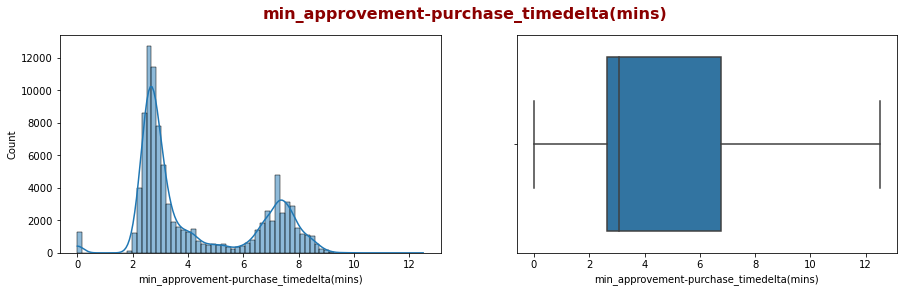

In [107]:
# visualisation effet transformation log
cols_to_log_transform = ['last_order_amount', 'mean_order_amount', 'max_order_amount', 
                         'min_item_price', 'max_item_price', 'mean_item_price',
                         'mean_approvement-purchase_timedelta(mins)',
                         'min_approvement-purchase_timedelta(mins)']
for f in cols_to_log_transform:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f, fontsize=16, color='darkred', weight=800)
    g1 = sns.histplot(data_for_clustering[f].apply(lambda x : np.log(1+x)),
                      kde=True, ax=axes[0])
    g2 = sns.boxplot(data_for_clustering[f].apply(lambda x : np.log(1+x)),
                     ax=axes[1])

## 4.2. Transformations log nécessaires

In [108]:
for f in cols_to_log_transform:
    data_for_clustering[f] = data_for_clustering[f].apply(lambda x : np.log(1+x))

## 4.3. Analyse univariée 2

<ipython-input-109-4bad29089acb>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2, figsize=(15, 4))
<ipython-input-109-4bad29089acb>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))
<ipython-input-109-4bad29089acb>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt

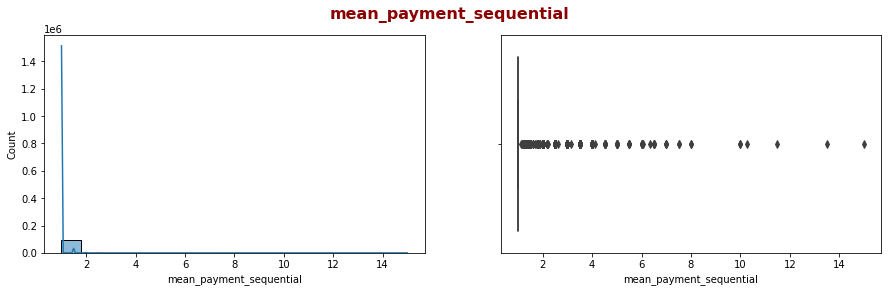

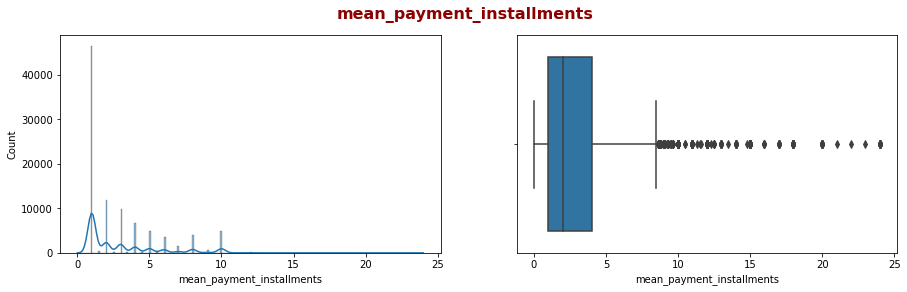

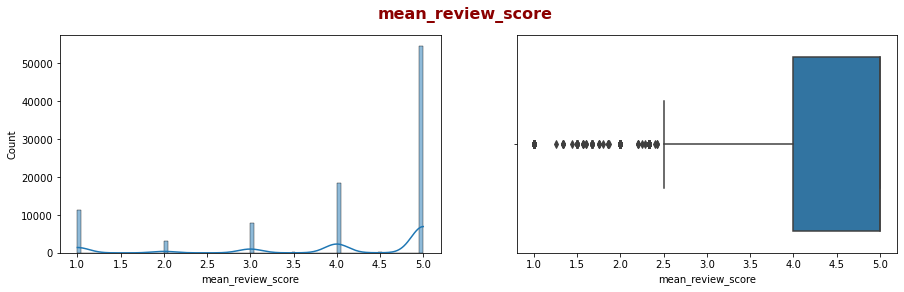

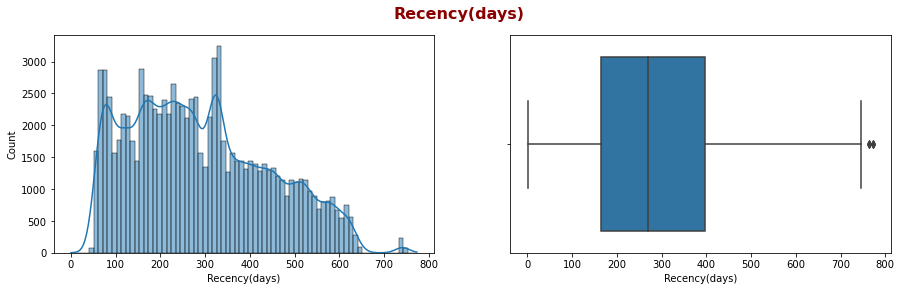

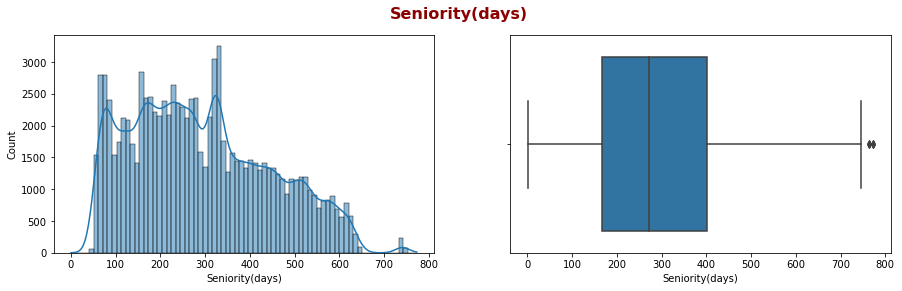

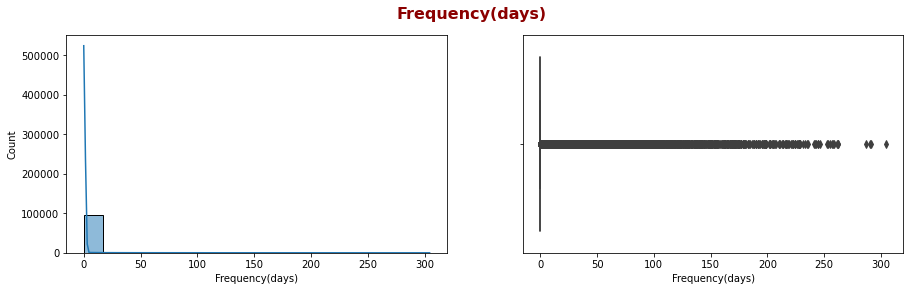

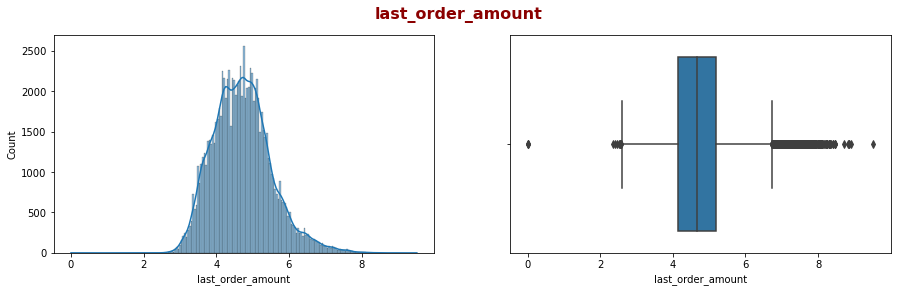

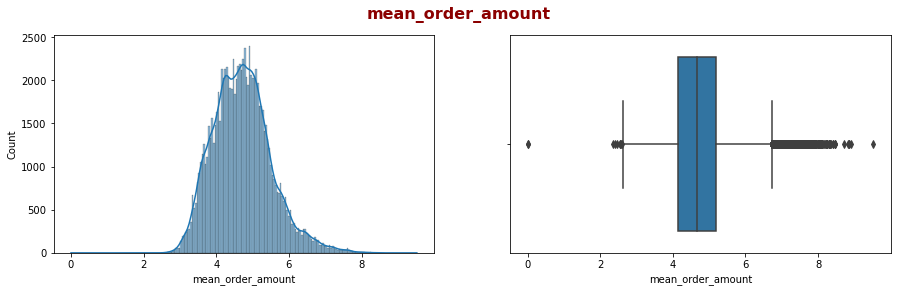

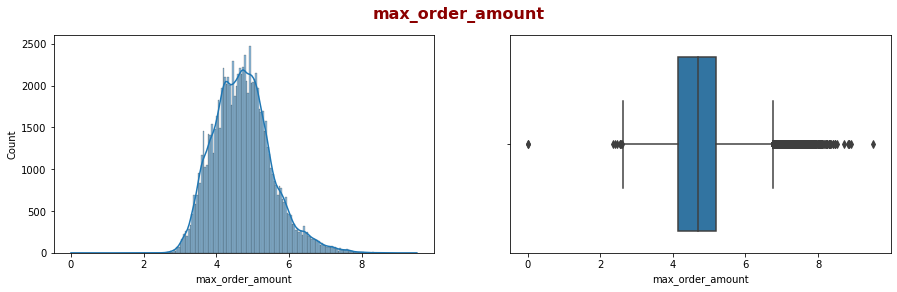

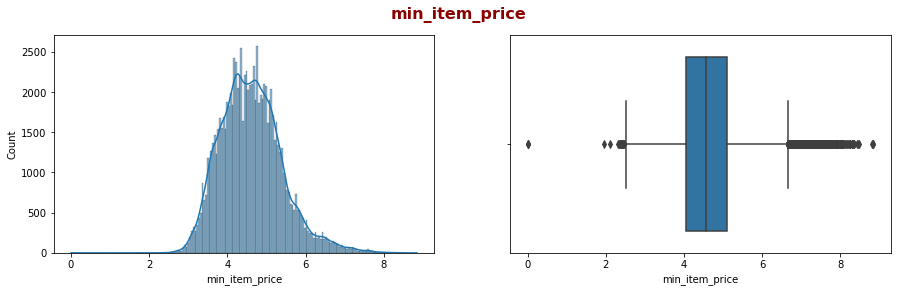

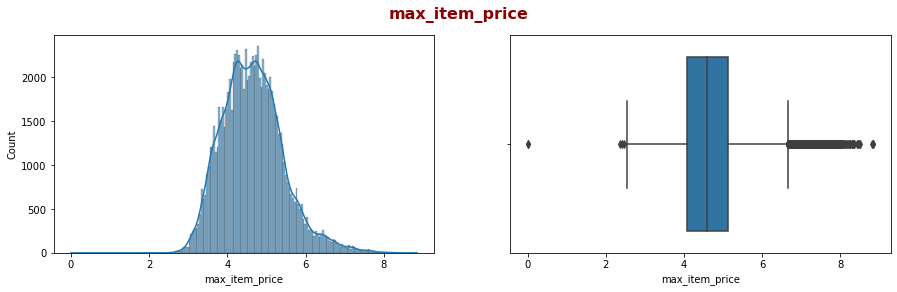

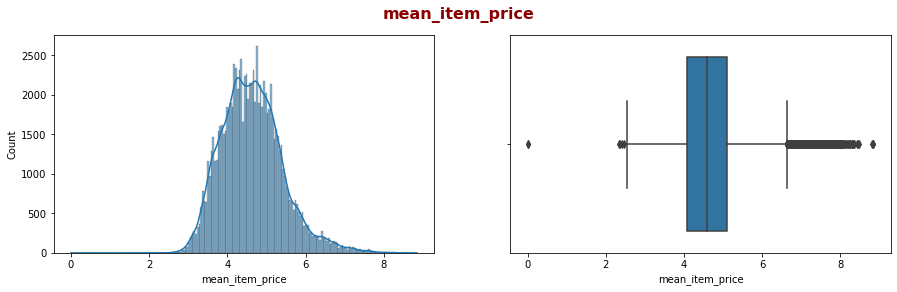

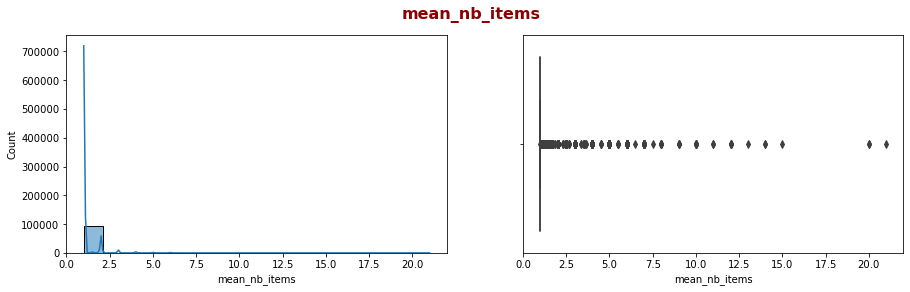

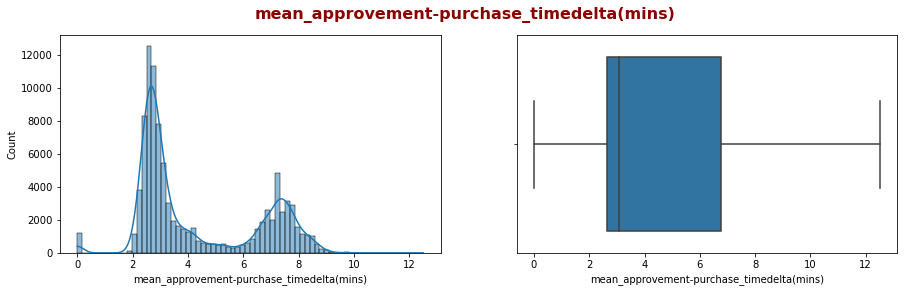

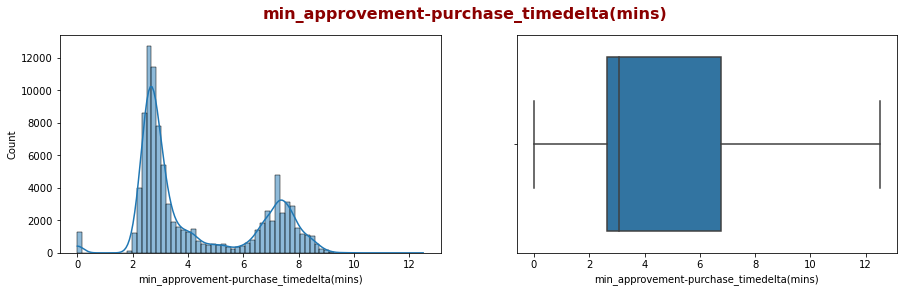

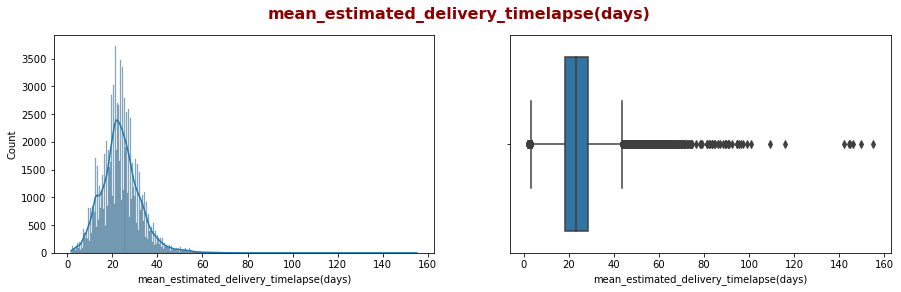

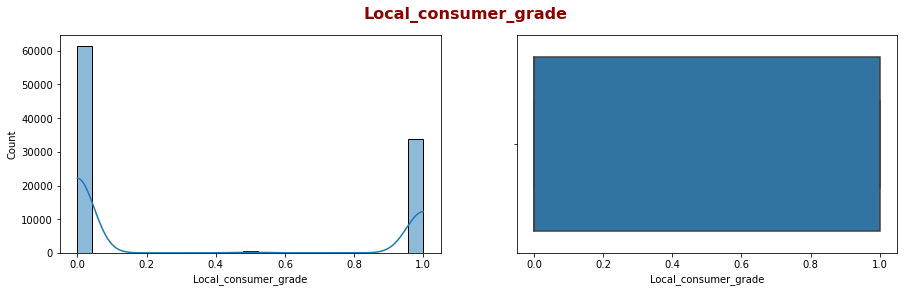

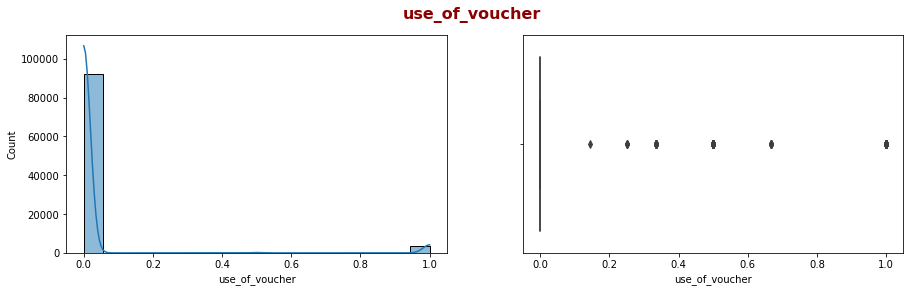

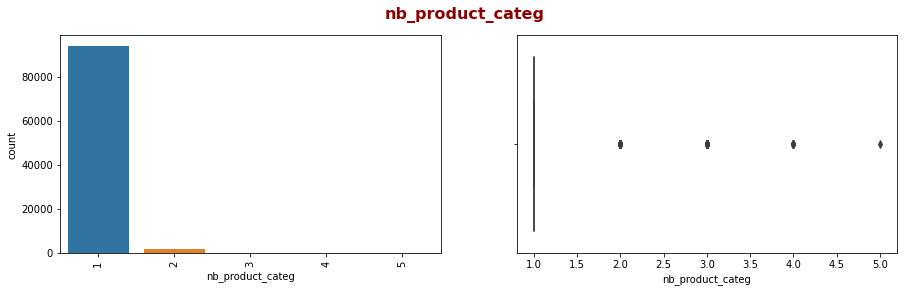

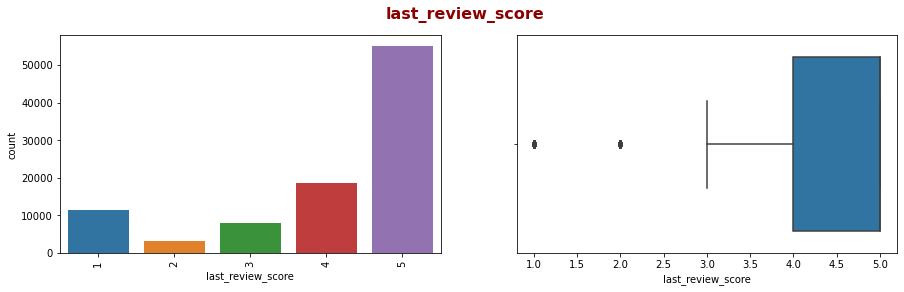

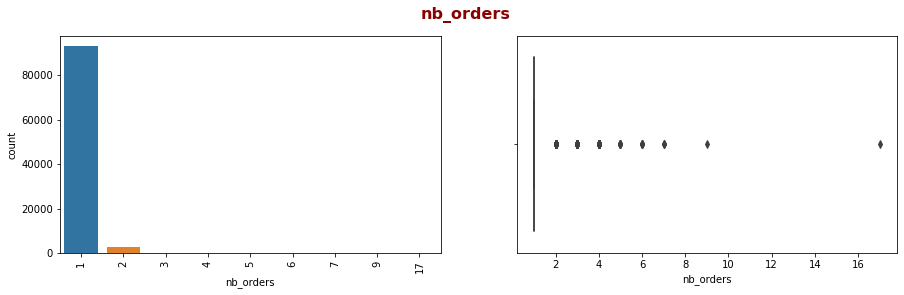

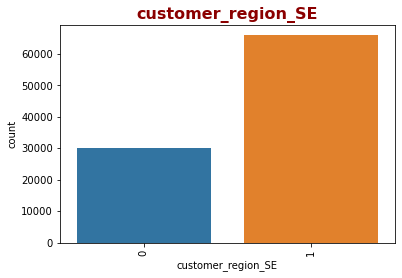

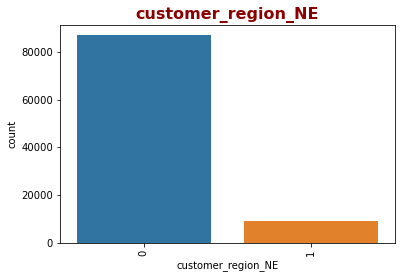

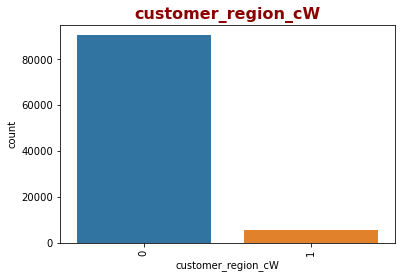

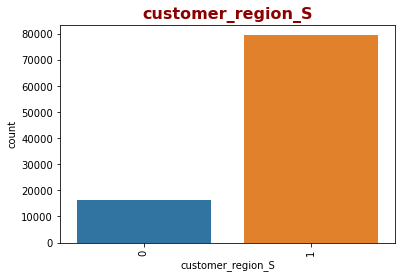

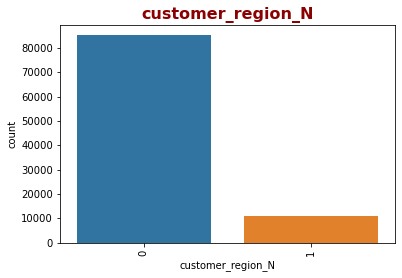

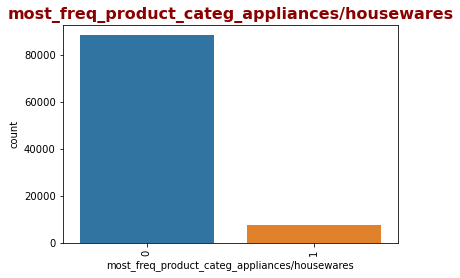

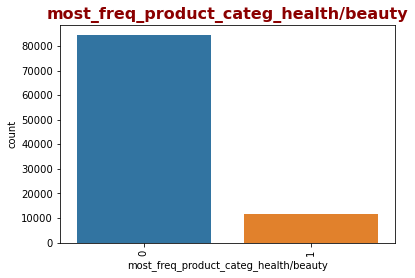

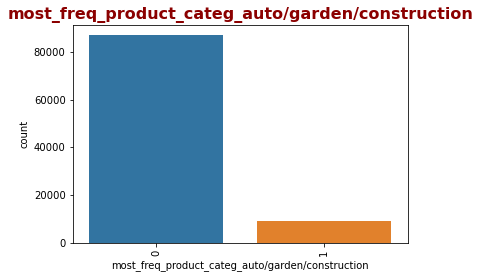

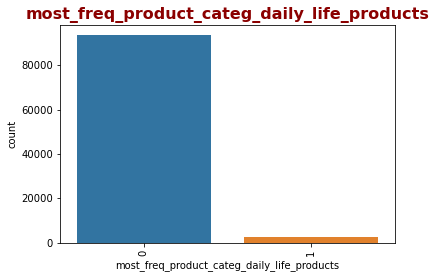

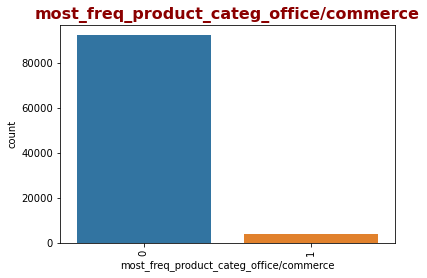

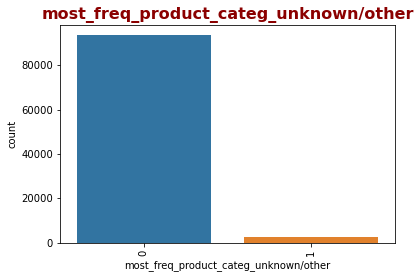

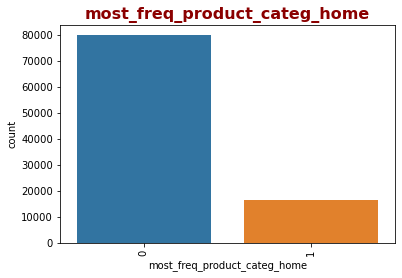

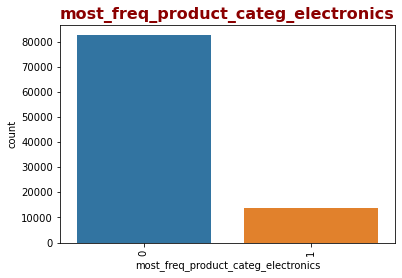

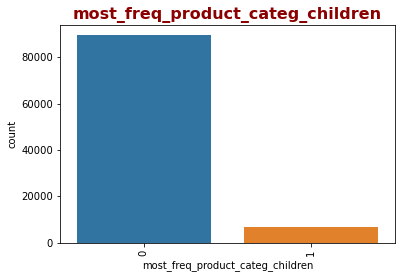

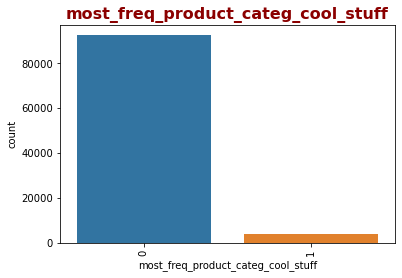

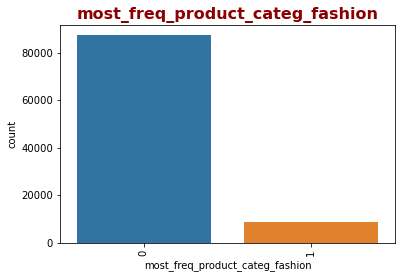

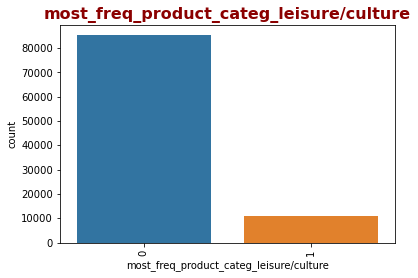

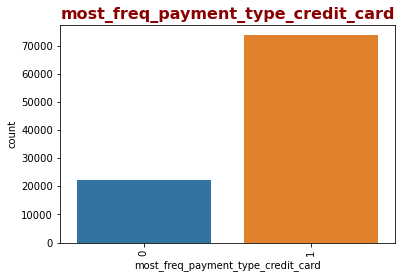

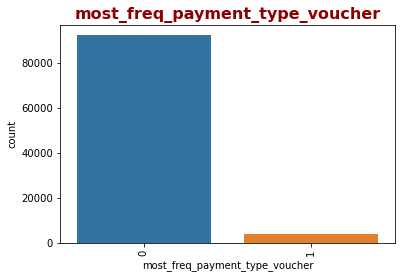

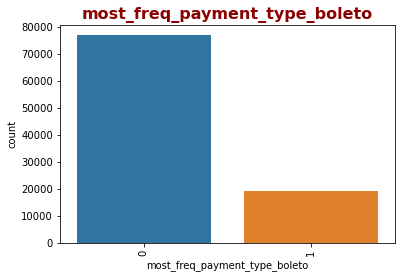

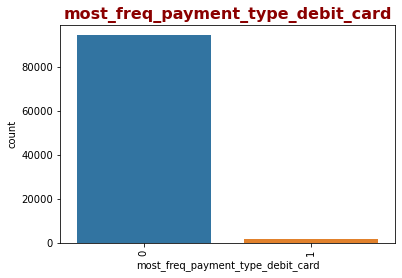

In [109]:
for f in num_c_features:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f, fontsize=16, color='darkred', weight=800)
    g1 = sns.histplot(x=f, data=data_for_clustering, kde=True, ax=axes[0])
    g2 = sns.boxplot(x=f, data=data_for_clustering, ax=axes[1])

for f in num_d_features:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f, fontsize=16, color='darkred', weight=800)
    g1 = sns.countplot(x=f, data=data_for_clustering, ax=axes[0])
    g1.tick_params(axis='x', rotation=90)
    g2 = sns.boxplot(x=f, data=data_for_clustering, ax=axes[1])
    
for f in bool_features:
    plt.figure(figsize=(6,4))
    plt.title(f, fontsize=16, color='darkred', weight=800)
    g = sns.countplot(x=f, data=data_for_clustering)
    g.tick_params(axis='x', rotation=90)

## 4.4. Analyse multivariée

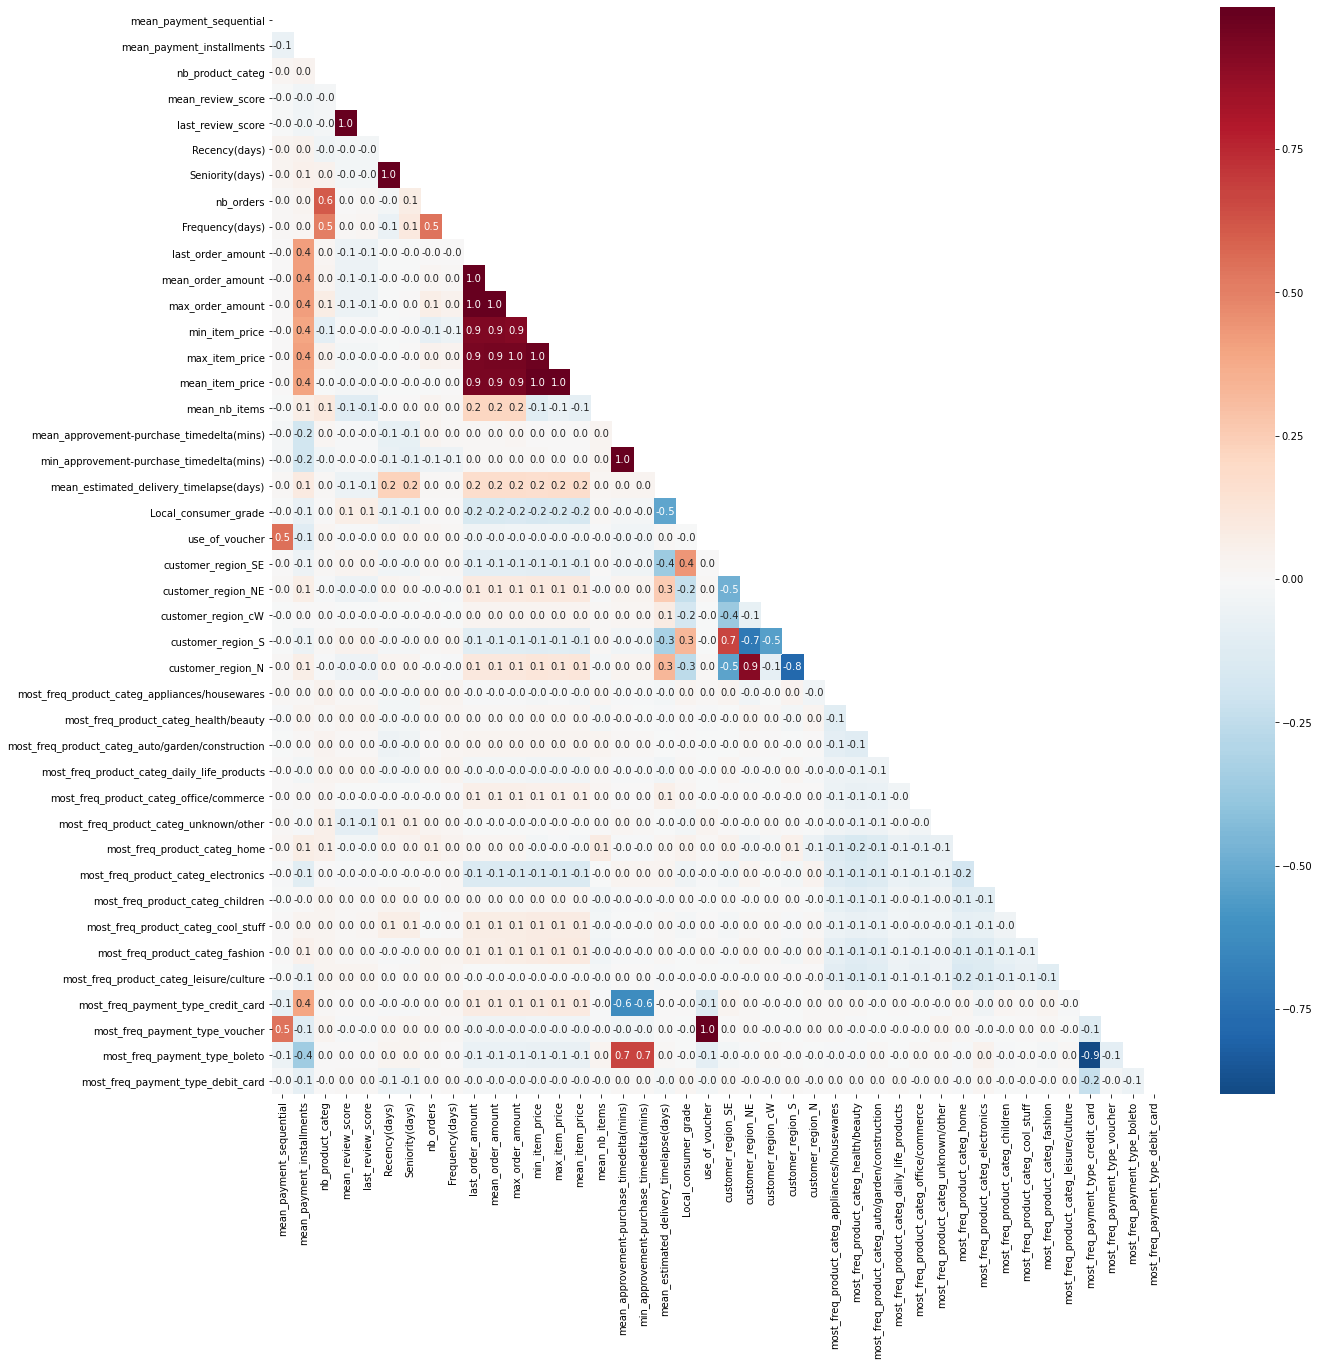

In [110]:
data = data_for_clustering
plt.figure(figsize=(20,20))
corr = data.corr()
MASK = np.triu(corr)
sns.heatmap(corr,annot=True, fmt='.1f', cmap ="RdBu_r",
            center=0, mask=MASK,
            xticklabels=corr.columns,
            yticklabels=corr.columns)
plt.show()

## 4.5. suppression colonnes redondantes (coeff correl = 1.0)
Remarque: beaucoup de ces colonnes sont corrélées parce que la plupart des clients n'ont effectués qu'une seule commande dans le cas présent.

In [111]:
cols_to_drop = ['mean_review_score',
                'Seniority(days)',
                'last_order_amount',
                'max_order_amount',
                'min_item_price',
                'max_item_price',
                'mean_item_price',
                'min_approvement-purchase_timedelta(mins)',
                'use_of_voucher']
data_for_clustering_clean = data_for_clustering.drop(columns=cols_to_drop)

# 5. export df data_for_clustering cleané

In [112]:
data_for_clustering_clean.to_csv("data_for_clustering_clean.csv")

In [113]:
data_for_clustering_clean.describe()

,mean_payment_sequential,mean_payment_installments,nb_product_categ,last_review_score,Recency(days),nb_orders,Frequency(days),mean_order_amount,mean_nb_items,mean_approvement-purchase_timedelta(mins),mean_estimated_delivery_timelapse(days),Local_consumer_grade,customer_region_SE,customer_region_NE,customer_region_cW,customer_region_S,customer_region_N,most_freq_product_categ_appliances/housewares,most_freq_product_categ_health/beauty,most_freq_product_categ_auto/garden/construction,most_freq_product_categ_daily_life_products,most_freq_product_categ_office/commerce,most_freq_product_categ_unknown/other,most_freq_product_categ_home,most_freq_product_categ_electronics,most_freq_product_categ_children,most_freq_product_categ_cool_stuff,most_freq_product_categ_fashion,most_freq_product_categ_leisure/culture,most_freq_payment_type_credit_card,most_freq_payment_type_voucher,most_freq_payment_type_boleto,most_freq_payment_type_debit_card
count,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000
mean,1.022307,2.902373,1.022134,4.069004,288.635502,1.034809,1.281456,4.712744,1.138815,4.286563,23.750433,0.356535,0.685741,0.095072,0.058213,0.828161,0.113730,0.079660,0.121909,0.095228,0.027556,0.040938,0.026765,0.169882,0.141827,0.069327,0.037358,0.091794,0.112866,0.766879,0.038149,0.200373,0.015672
std,0.189554,2.678872,0.156112,1.360414,153.416318,0.214384,12.011750,0.800983,0.524954,2.180412,8.783202,0.477128,0.464222,0.293315,0.234146,0.377242,0.317485,0.270767,0.327183,0.293531,0.163697,0.198148,0.161396,0.375531,0.348874,0.254010,0.189640,0.288736,0.316431,0.422821,0.191558,0.400281,0.124203
min,1.000000,0.000000,1.000000,1.000000,0.434132,1.000000,0.000000,0.000000,1.000000,0.000000,1.648993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,4.000000,164.319876,1.000000,0.000000,4.152928,1.000000,2.637866,18.337381,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,1.000000,5.000000,269.344572,1.000000,0.000000,4.674323,1.000000,3.085725,23.240191,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,1.000000,5.000000,397.785530,1.000000,0.000000,5.184645,1.000000,6.778647,28.413646,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,15.000000,24.000000,5.000000,5.000000,773.277870,17.000000,304.489456,9.522599,21.000000,12.508219,155.135463,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


----

In [114]:
# outlier mis en évidence après visualisation sur dimension réduite
data_for_clustering_clean[data_for_clustering_clean.nb_orders == 17]

,mean_payment_sequential,mean_payment_installments,nb_product_categ,last_review_score,Recency(days),nb_orders,Frequency(days),mean_order_amount,mean_nb_items,mean_approvement-purchase_timedelta(mins),mean_estimated_delivery_timelapse(days),Local_consumer_grade,customer_region_SE,customer_region_NE,customer_region_cW,customer_region_S,customer_region_N,most_freq_product_categ_appliances/housewares,most_freq_product_categ_health/beauty,most_freq_product_categ_auto/garden/construction,most_freq_product_categ_daily_life_products,most_freq_product_categ_office/commerce,most_freq_product_categ_unknown/other,most_freq_product_categ_home,most_freq_product_categ_electronics,most_freq_product_categ_children,most_freq_product_categ_cool_stuff,most_freq_product_categ_fashion,most_freq_product_categ_leisure/culture,most_freq_payment_type_credit_card,most_freq_payment_type_voucher,most_freq_payment_type_boleto,most_freq_payment_type_debit_card
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,1.0,1.352941,4,5,58.361817,17,27.166029,4.01758,1.005882,4.902795,13.550323,0.764706,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
